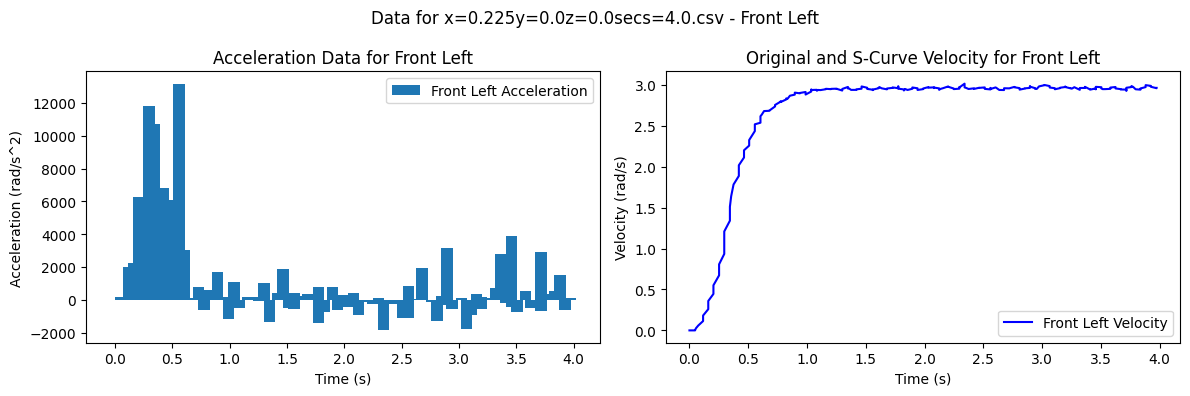

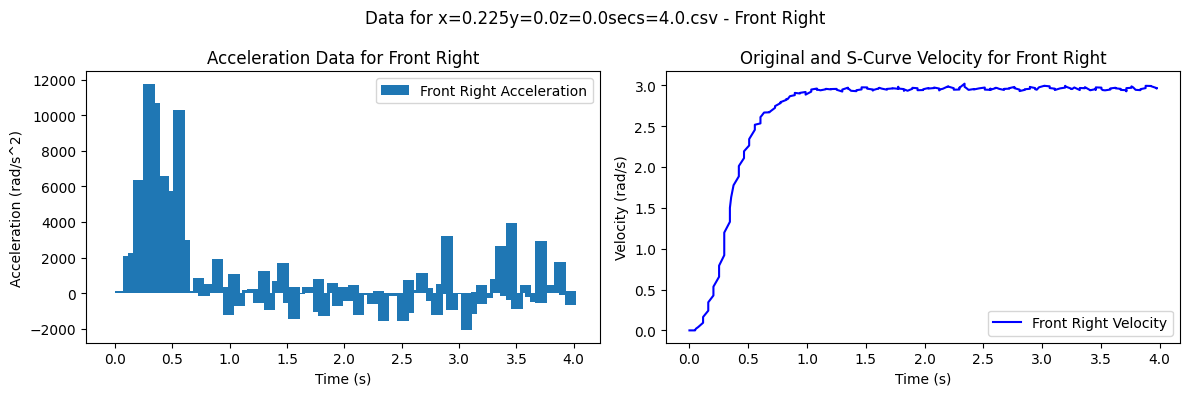

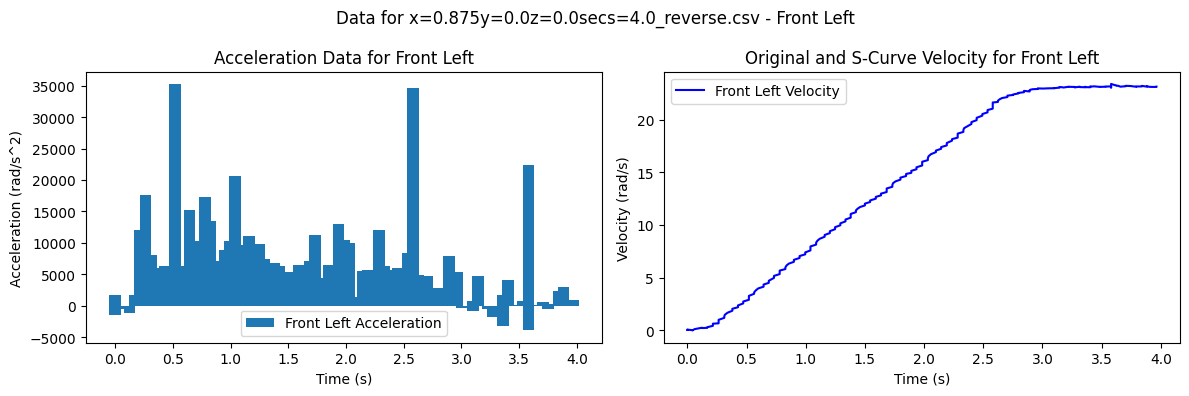

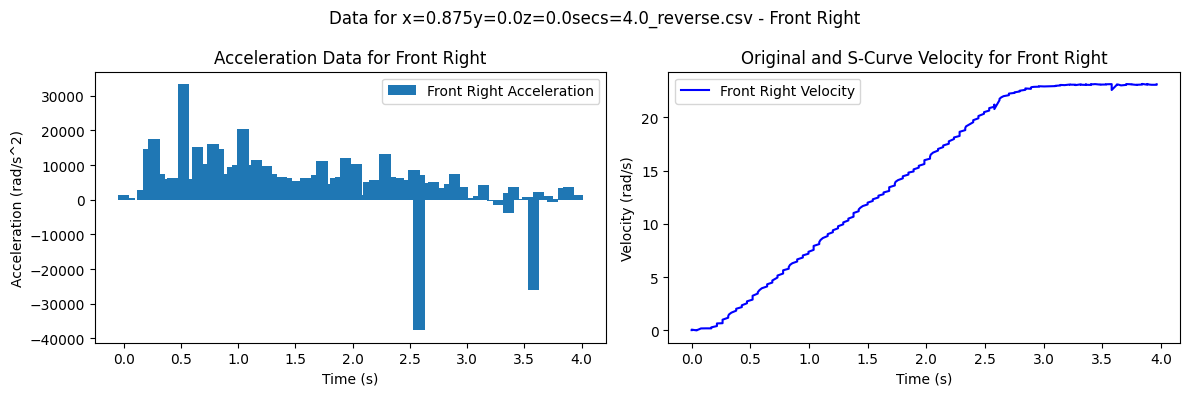

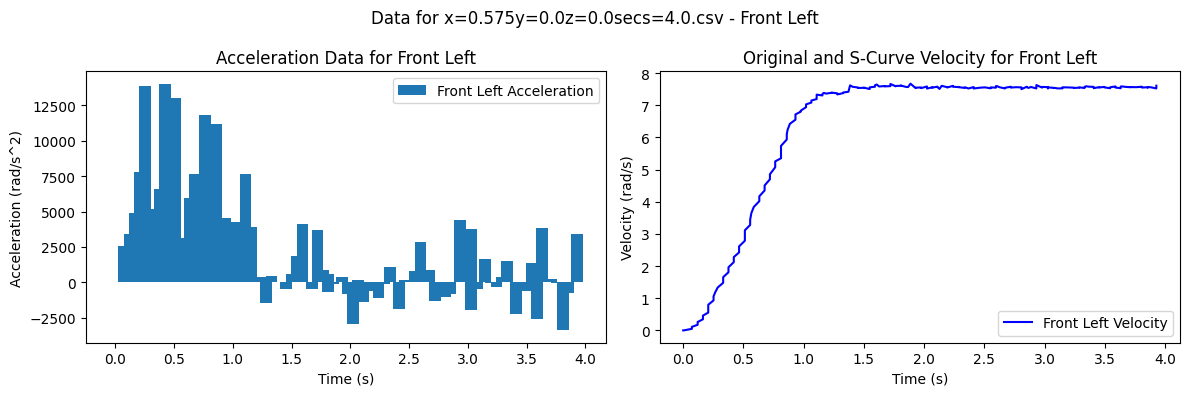

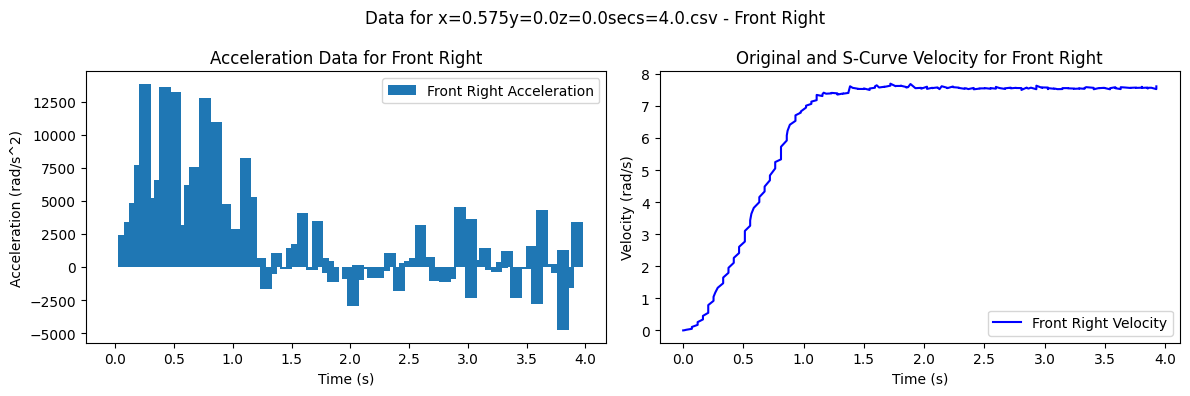

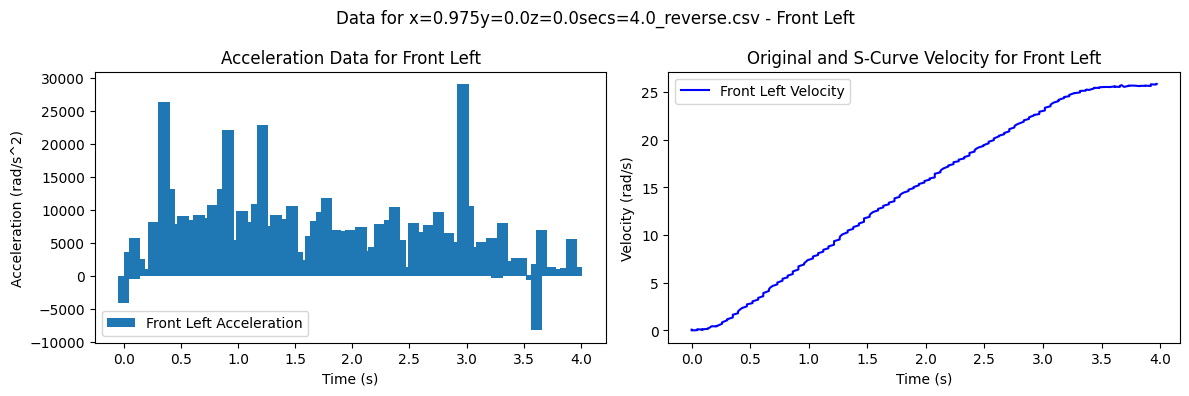

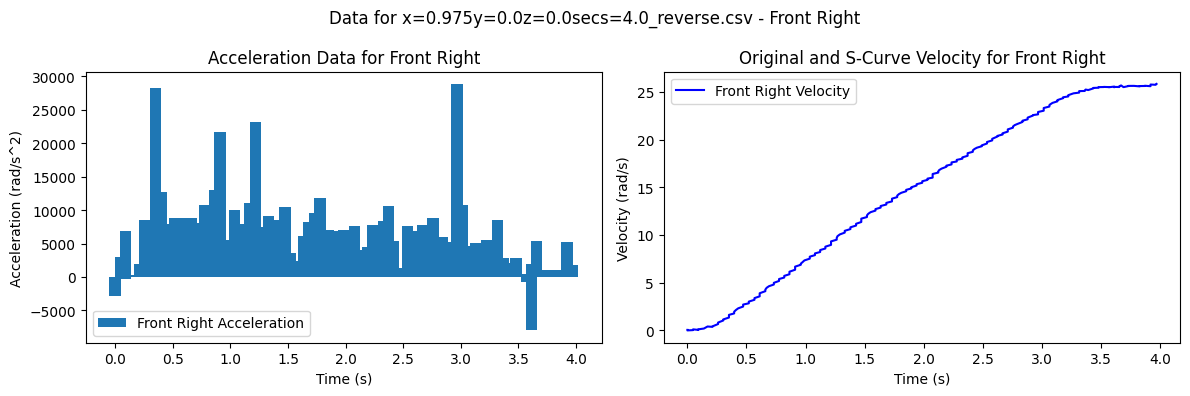

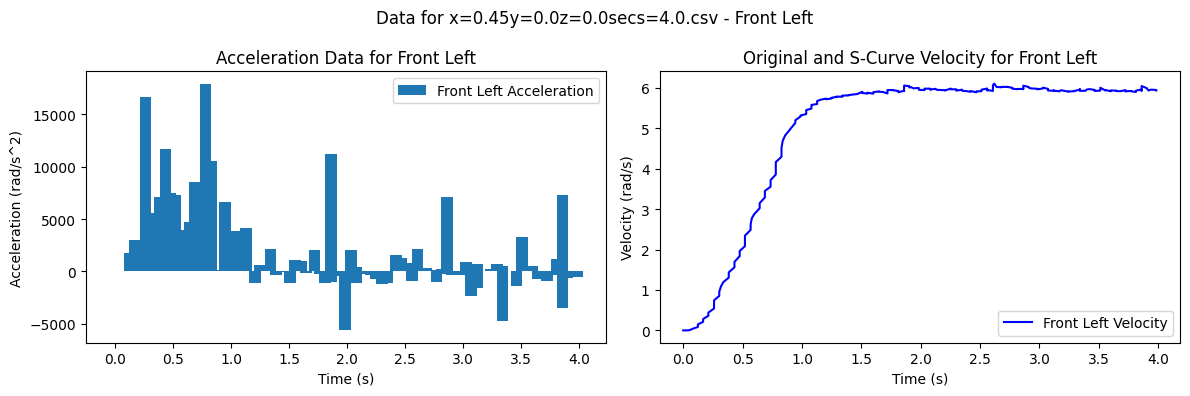

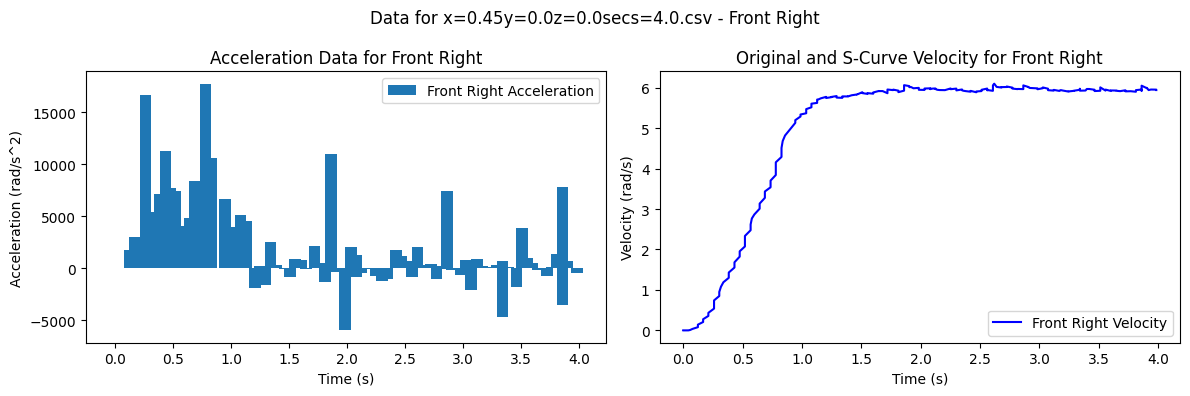

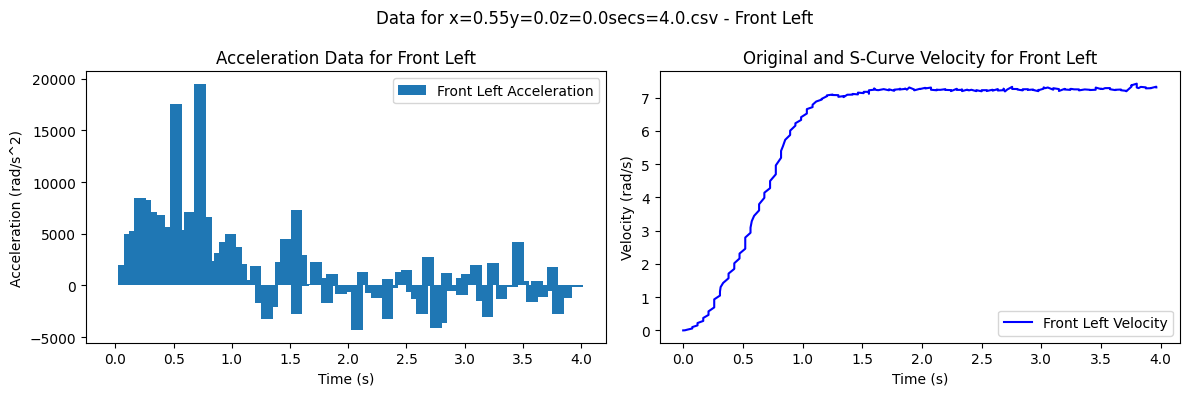

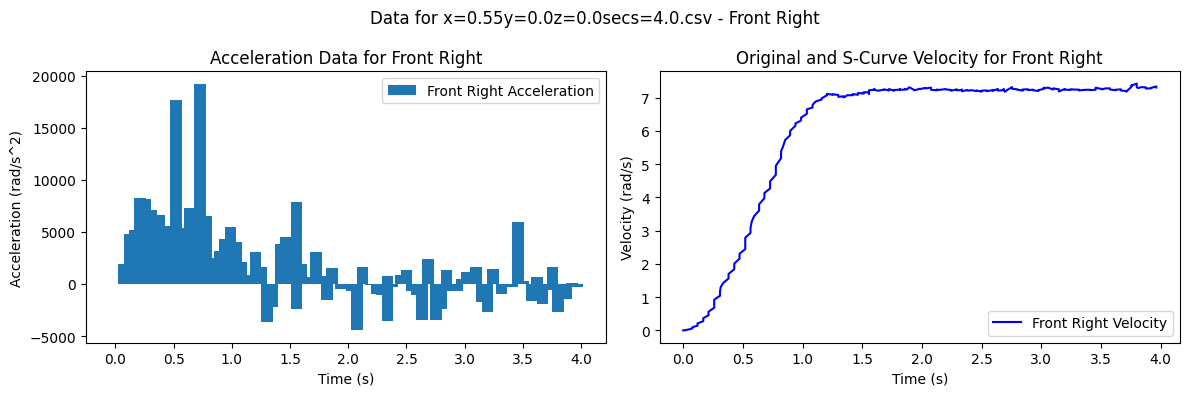

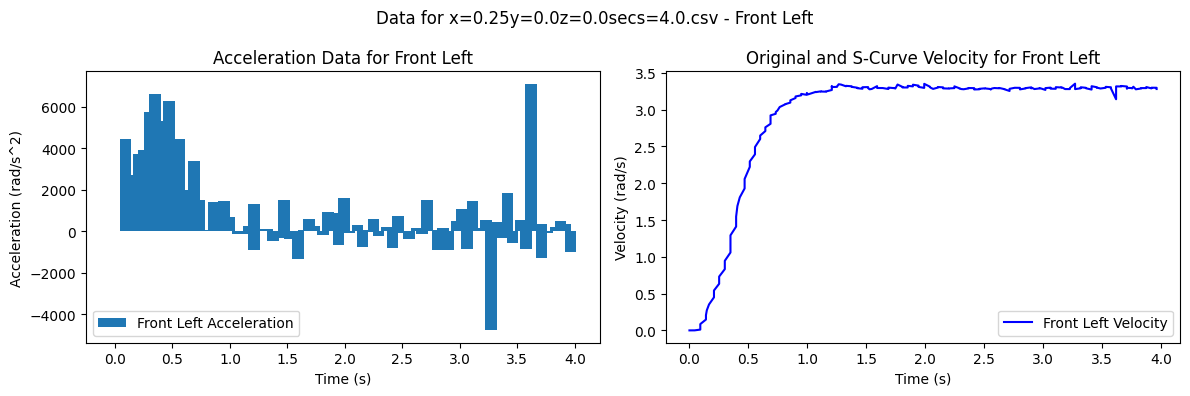

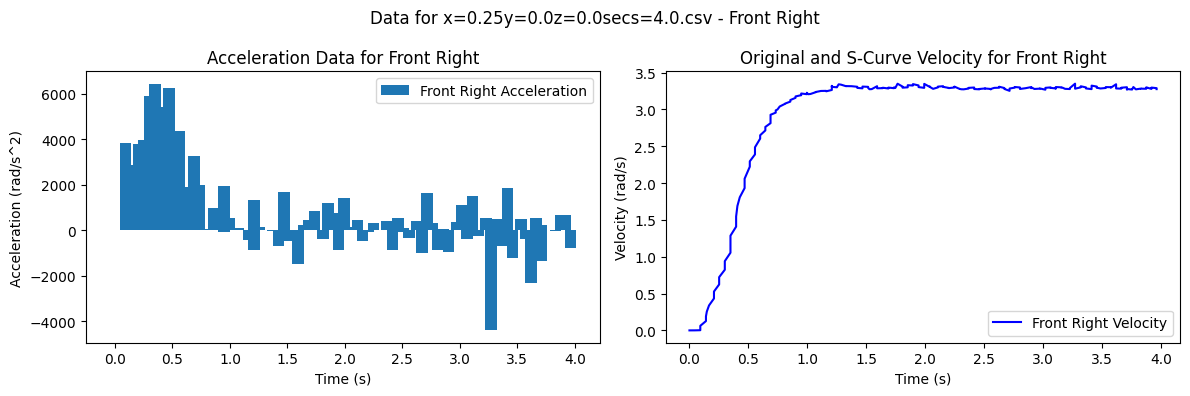

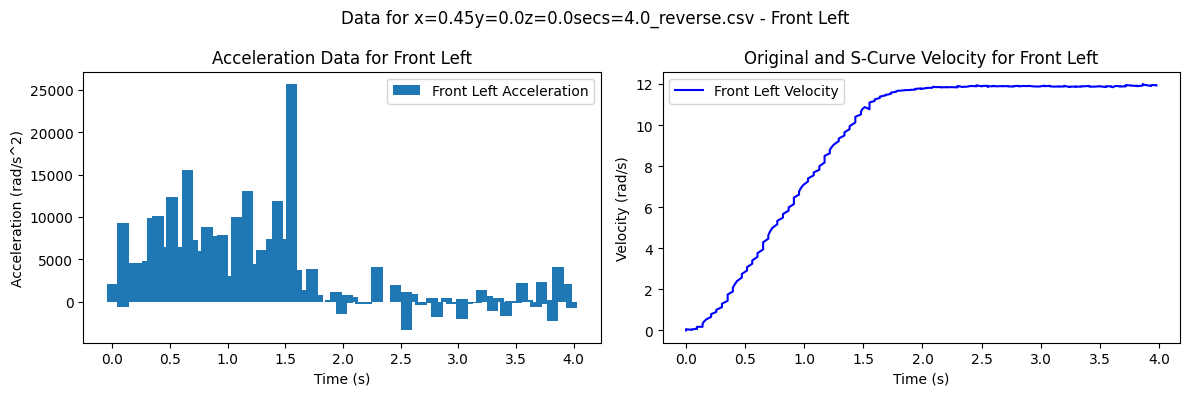

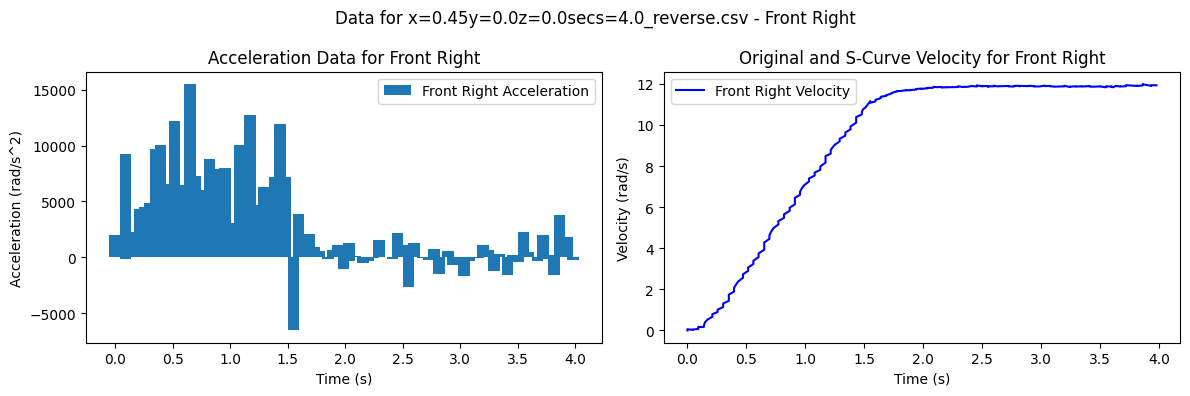

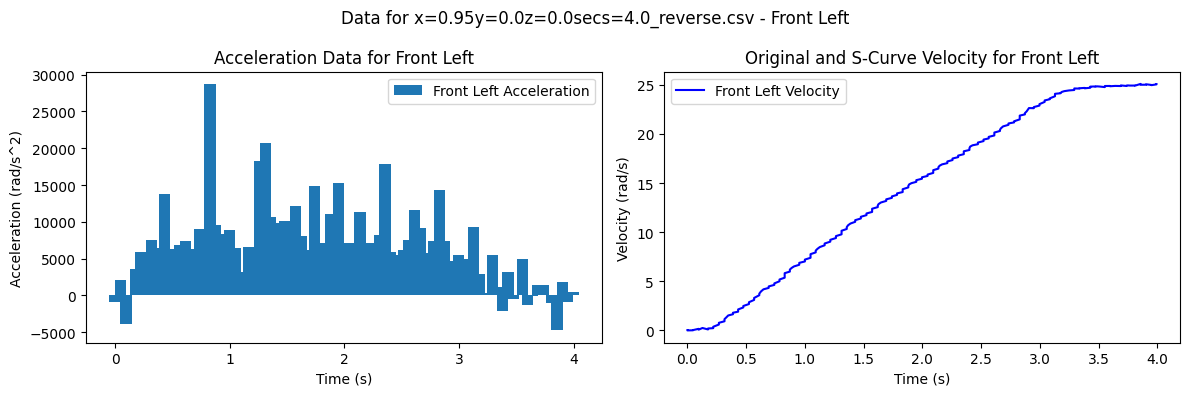

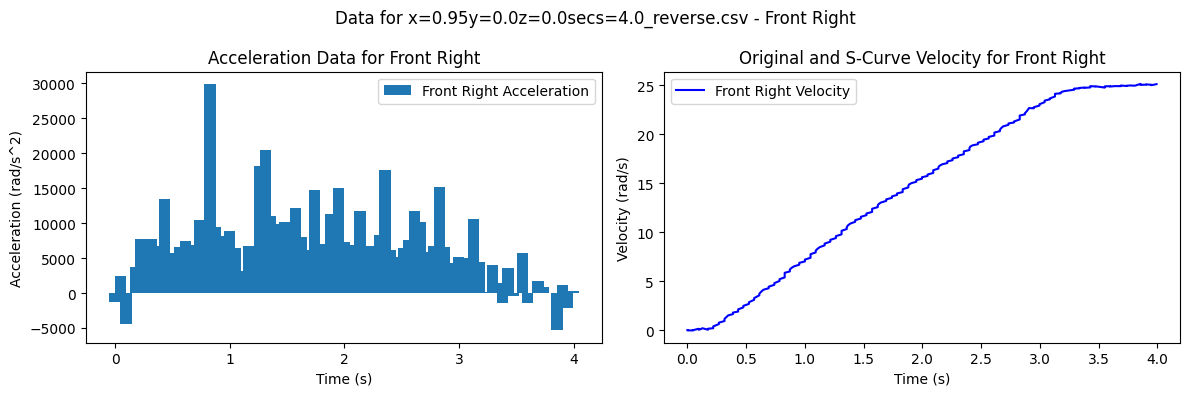

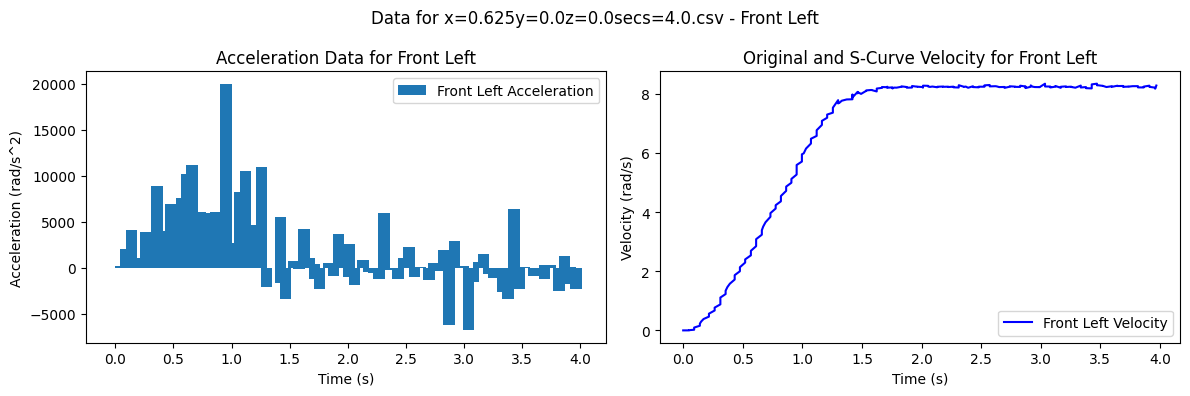

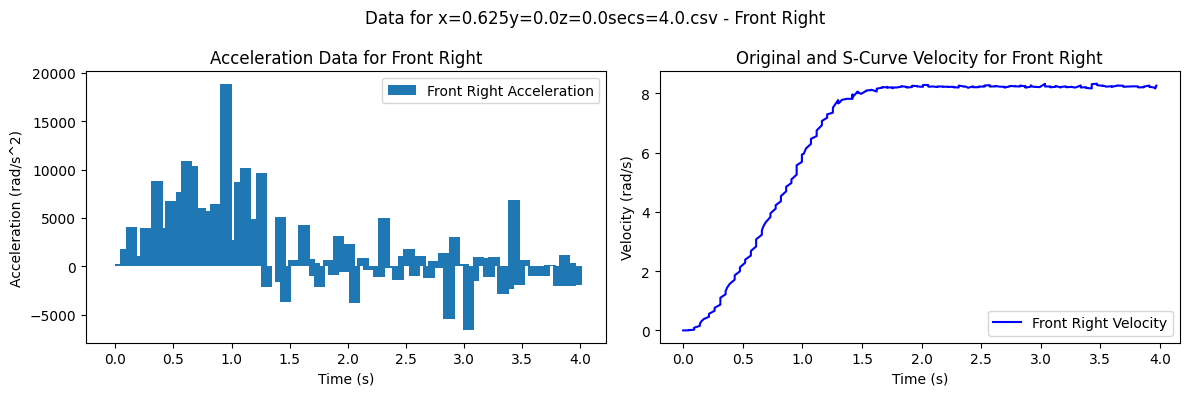

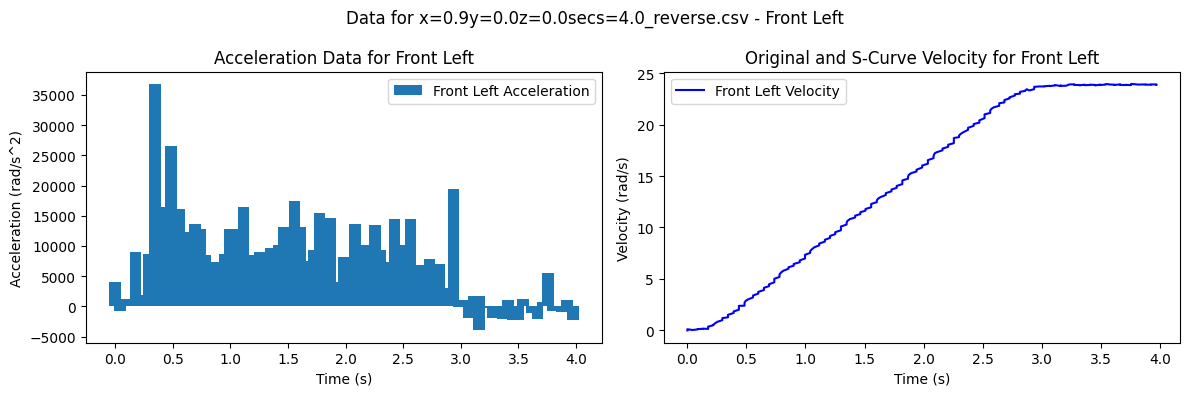

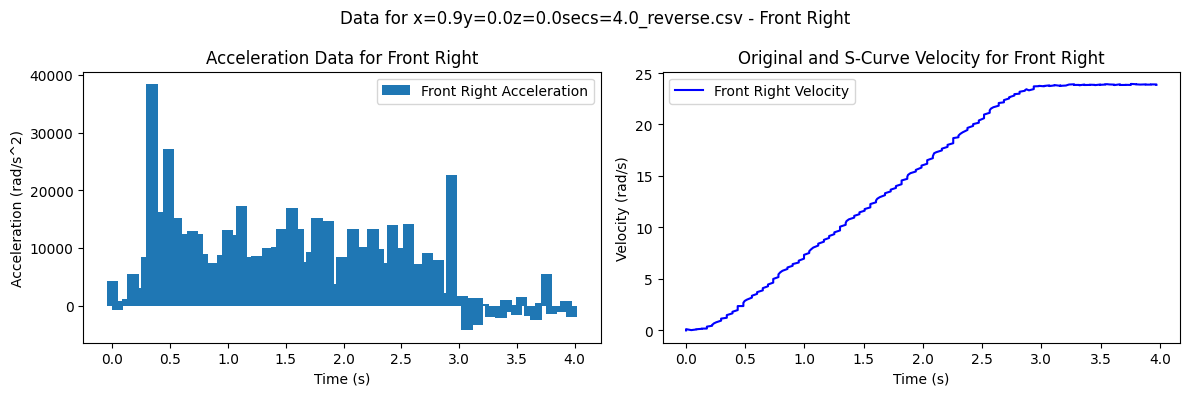

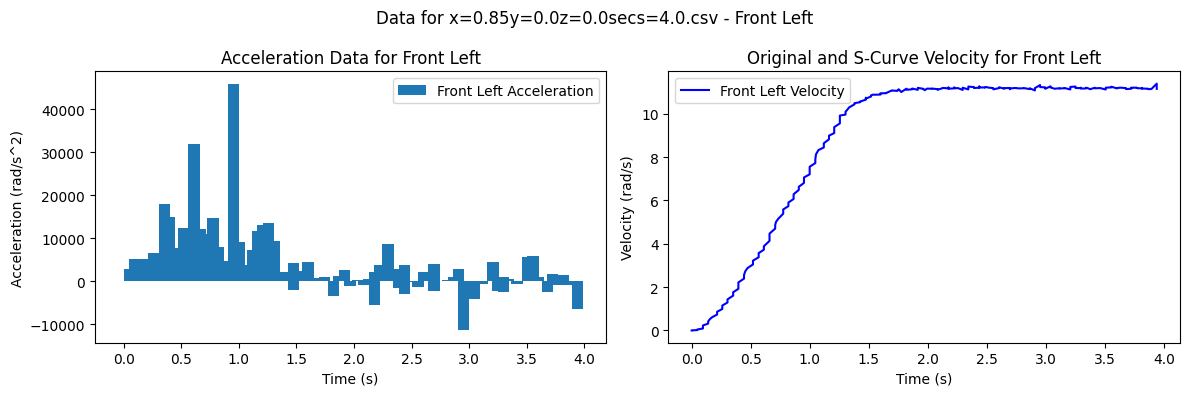

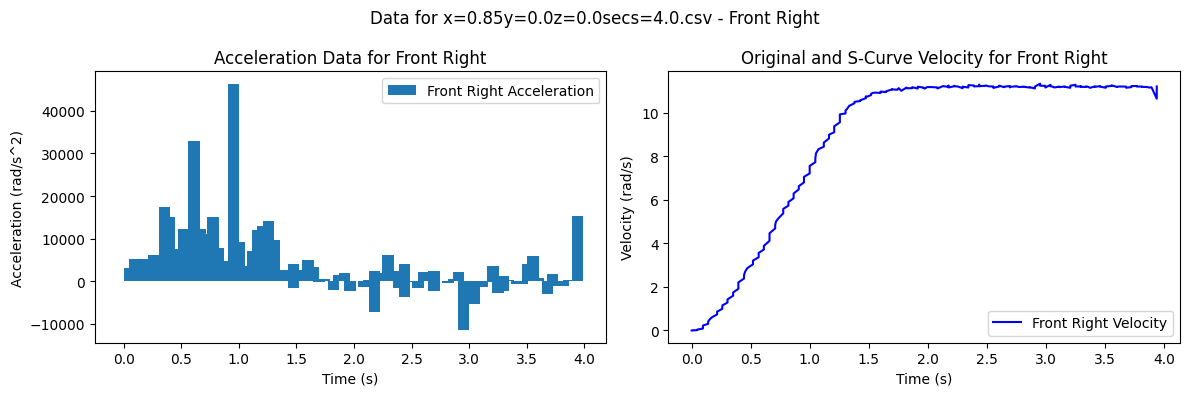

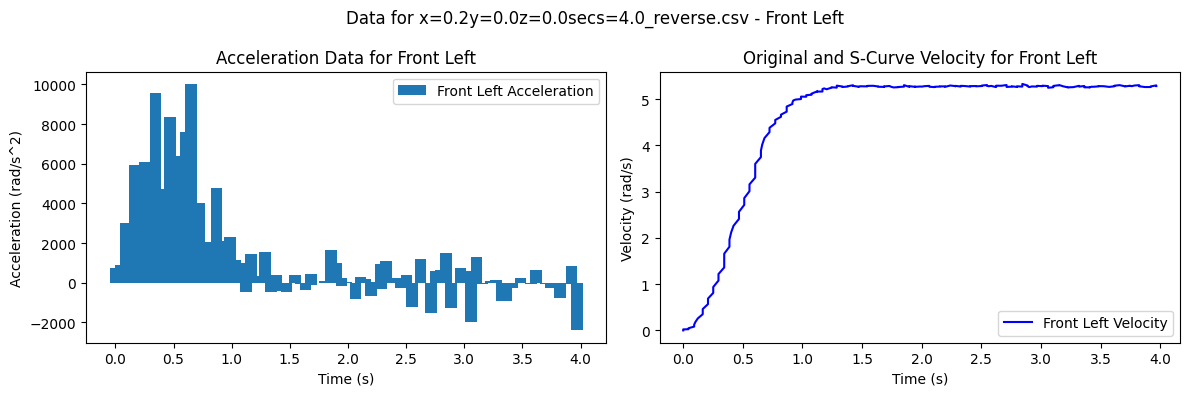

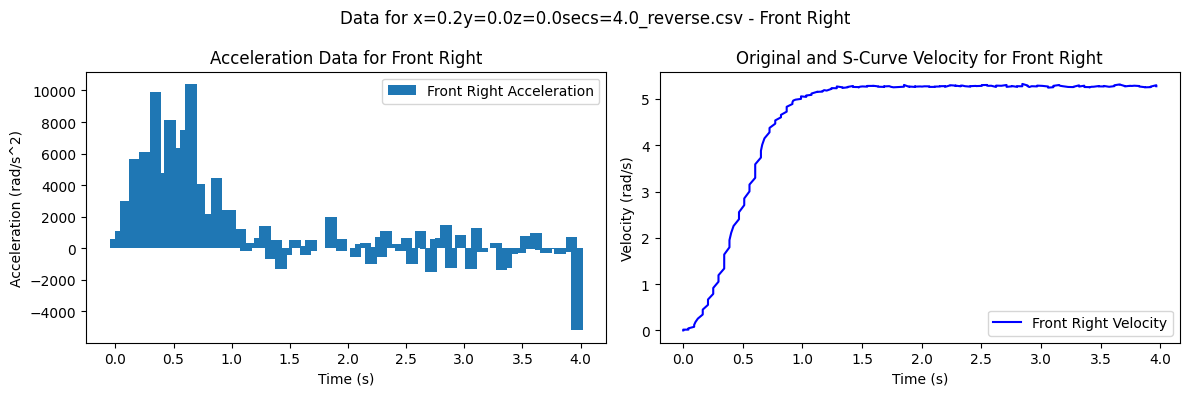

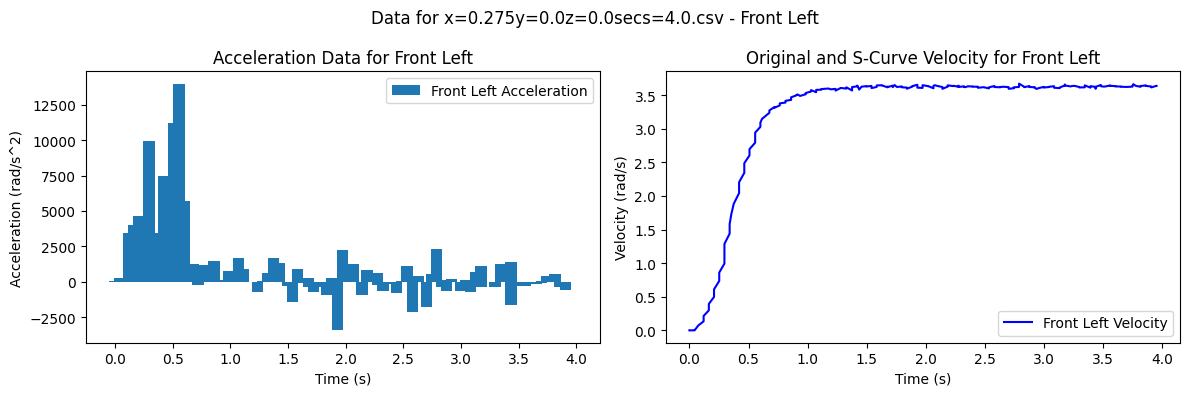

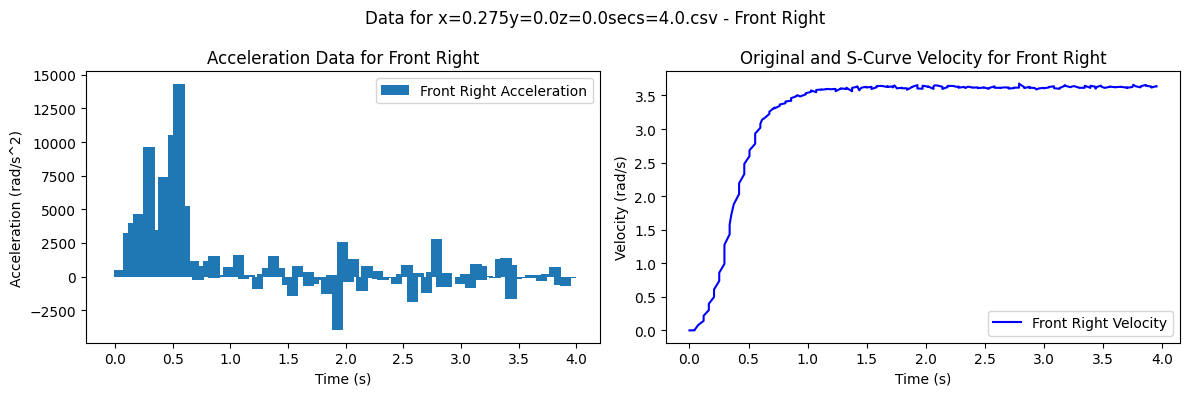

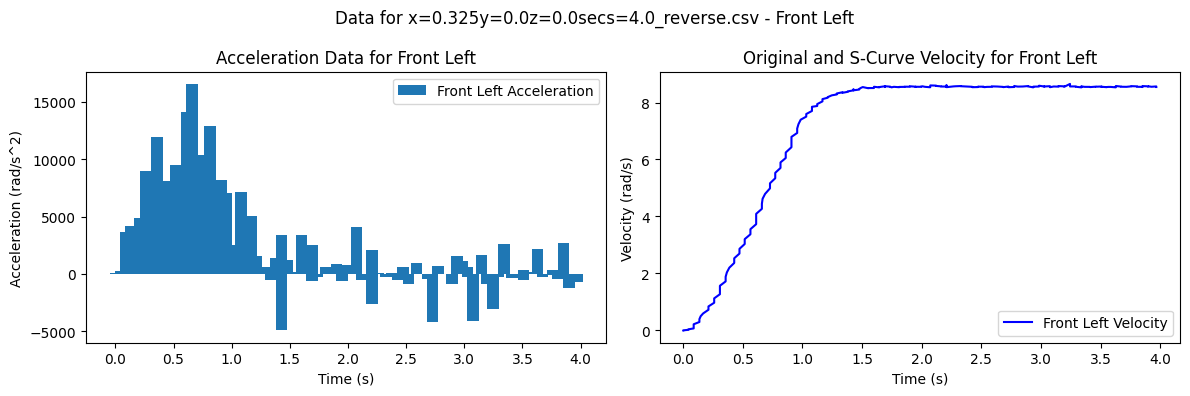

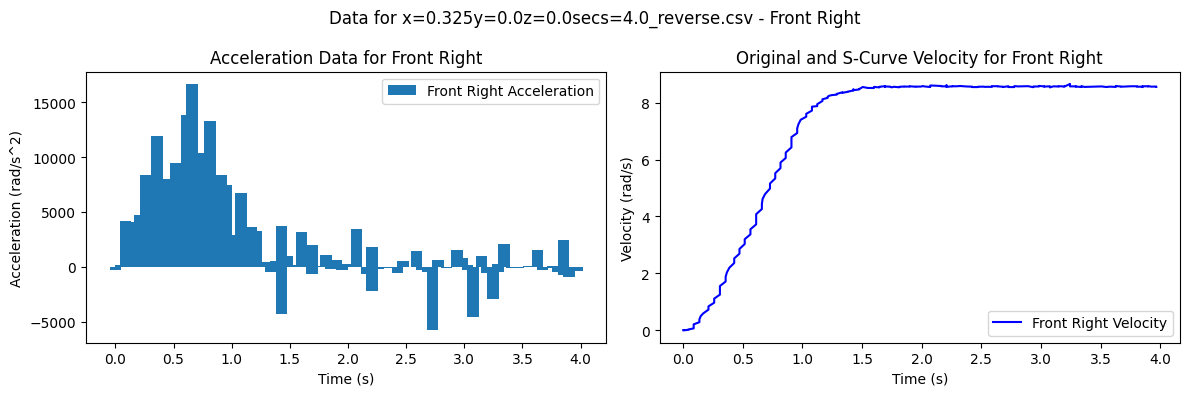

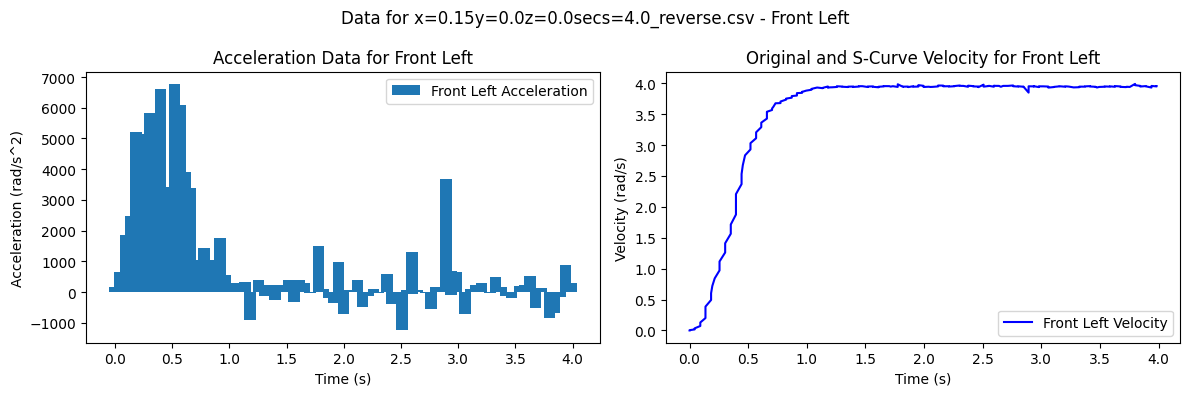

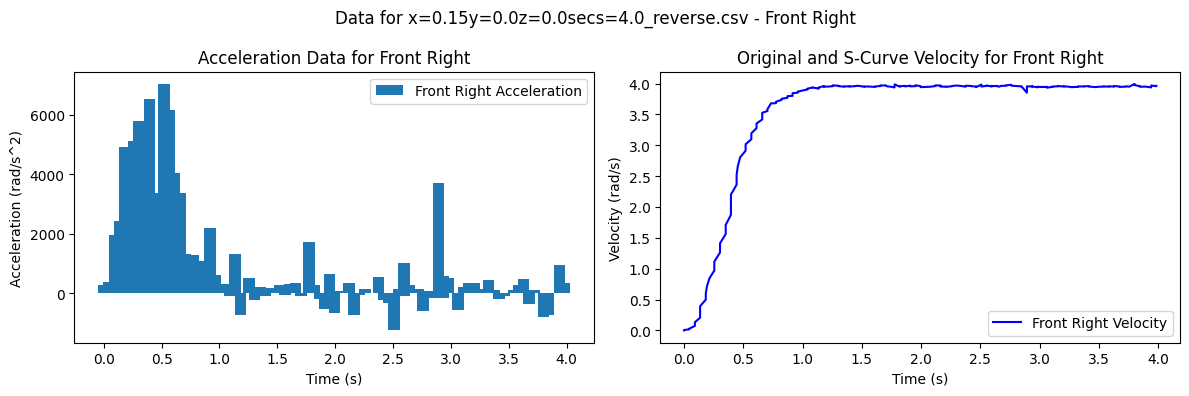

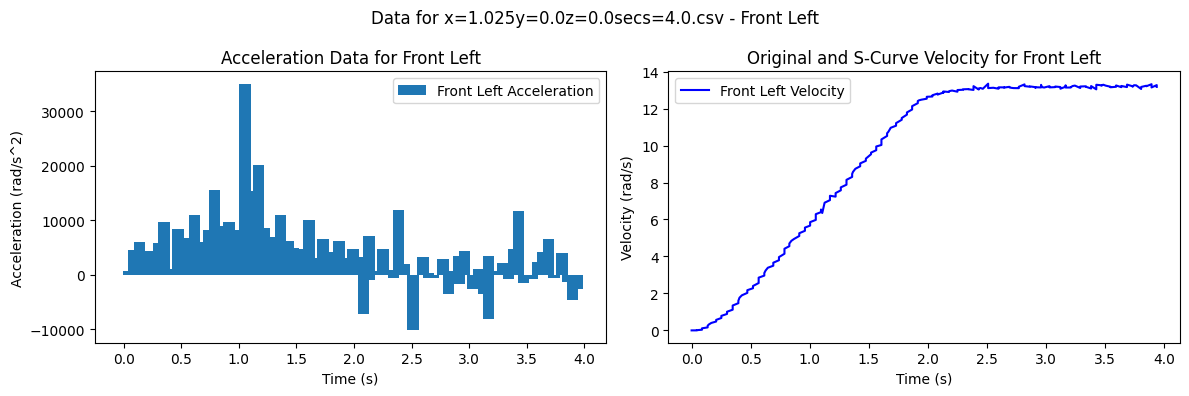

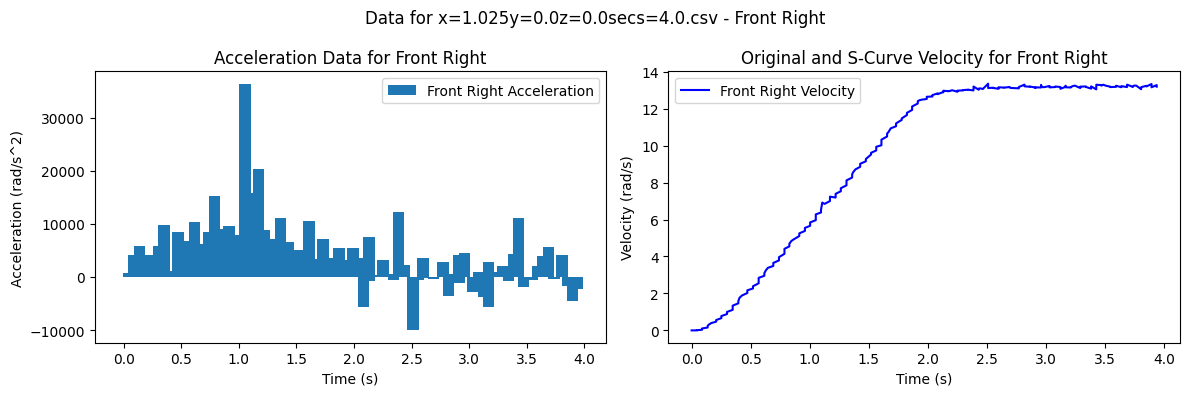

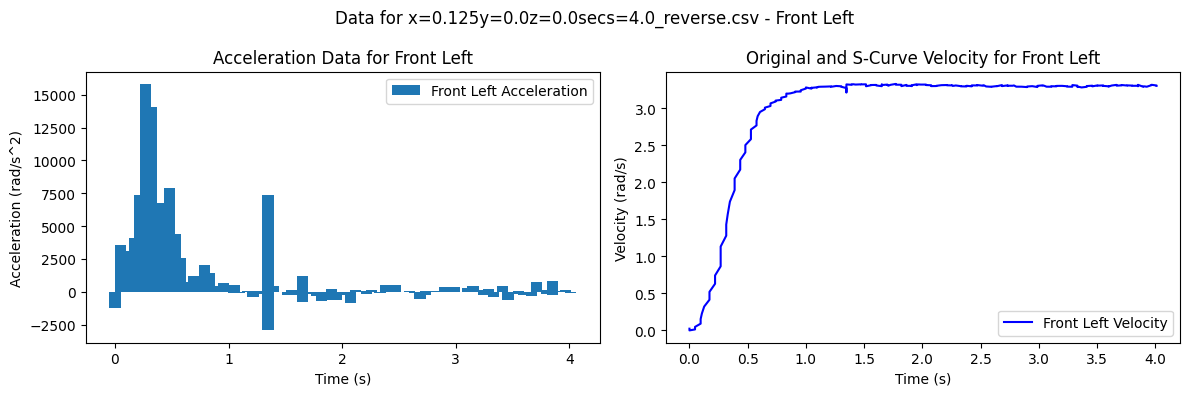

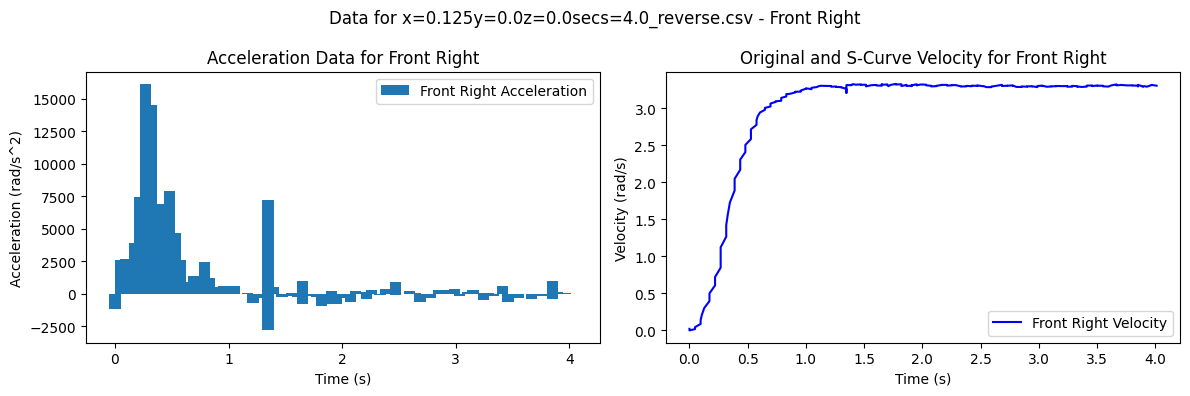

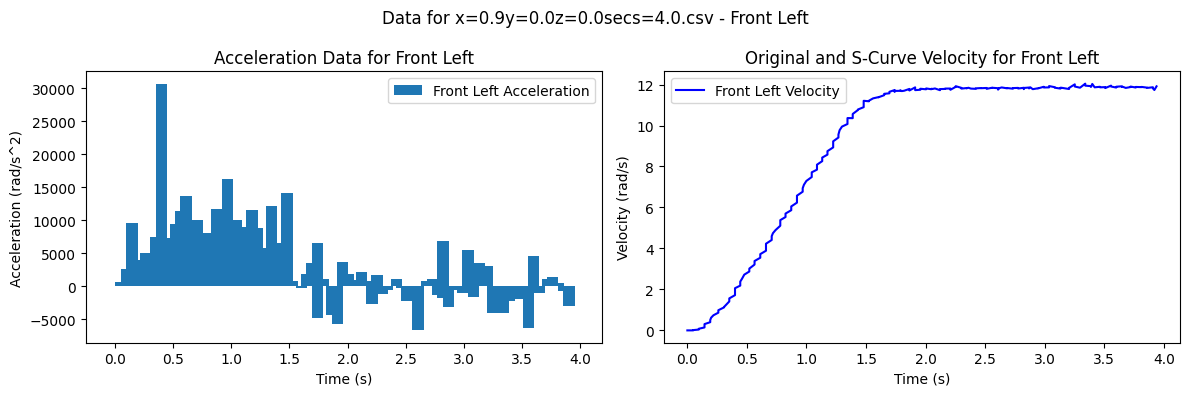

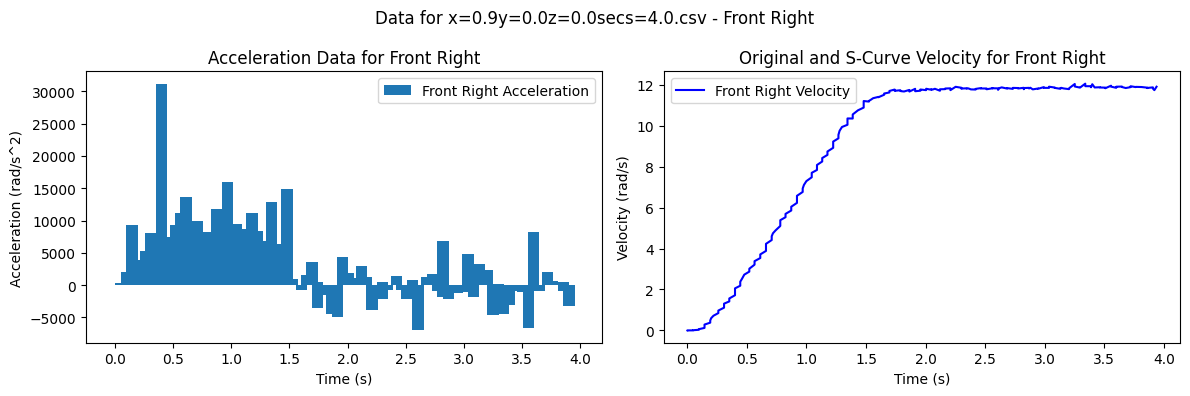

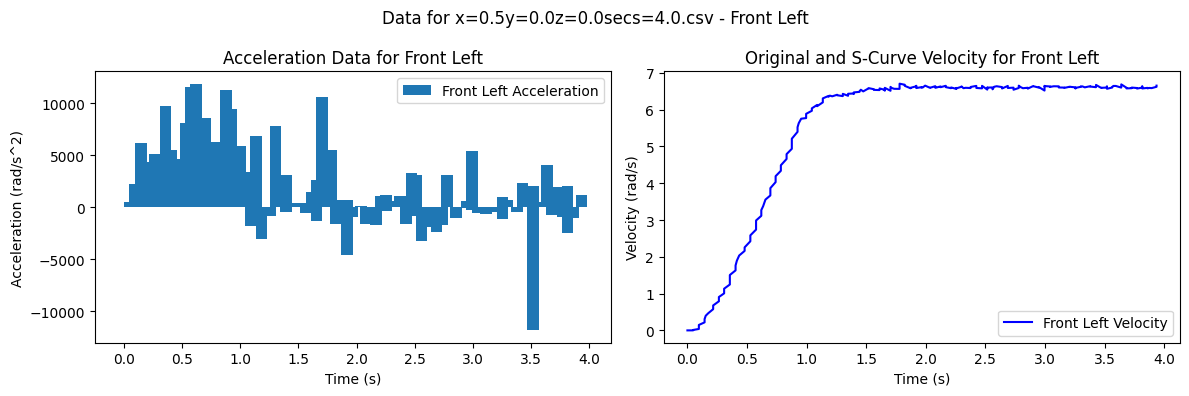

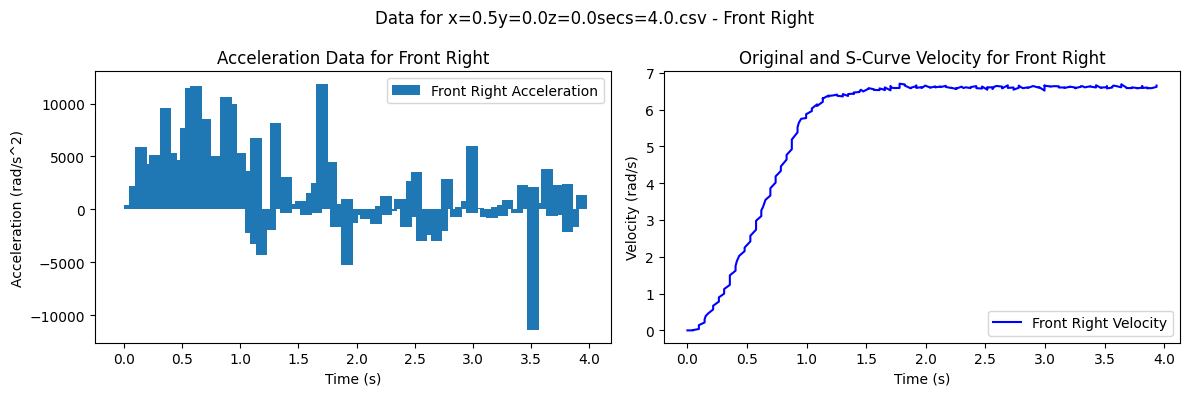

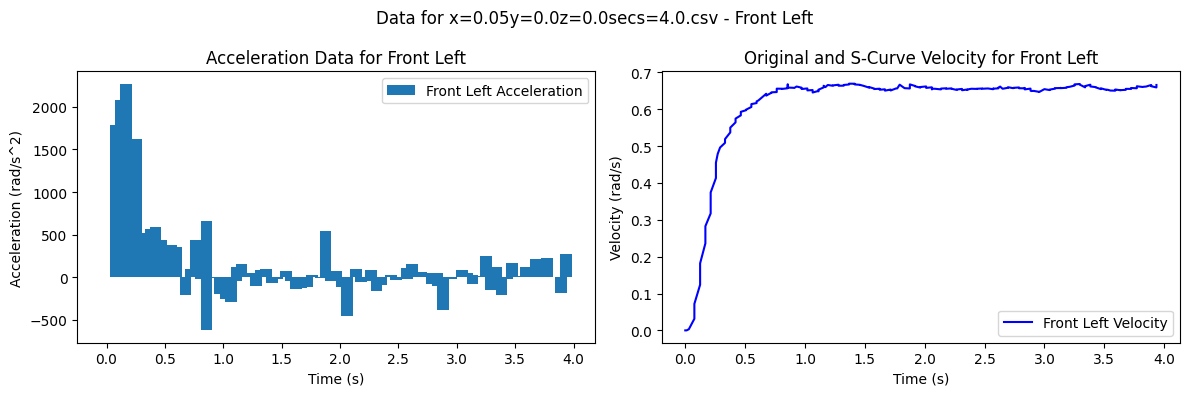

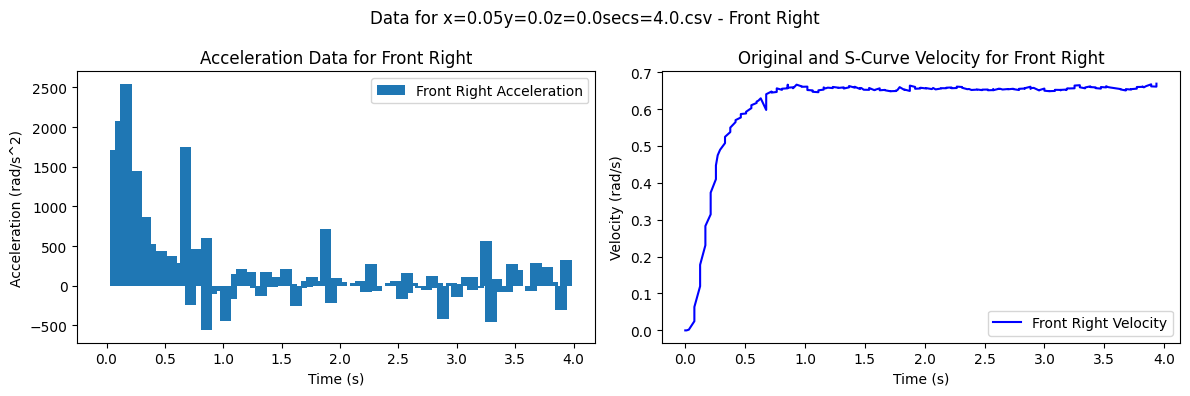

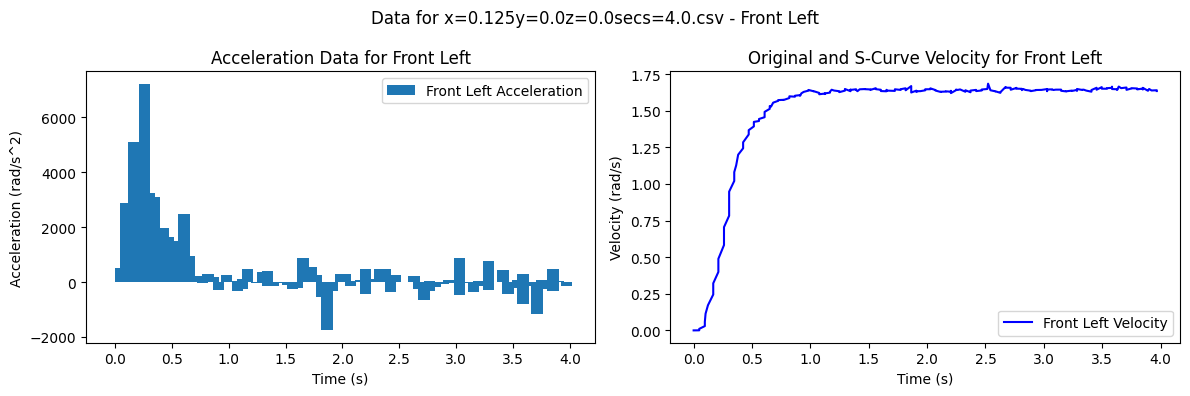

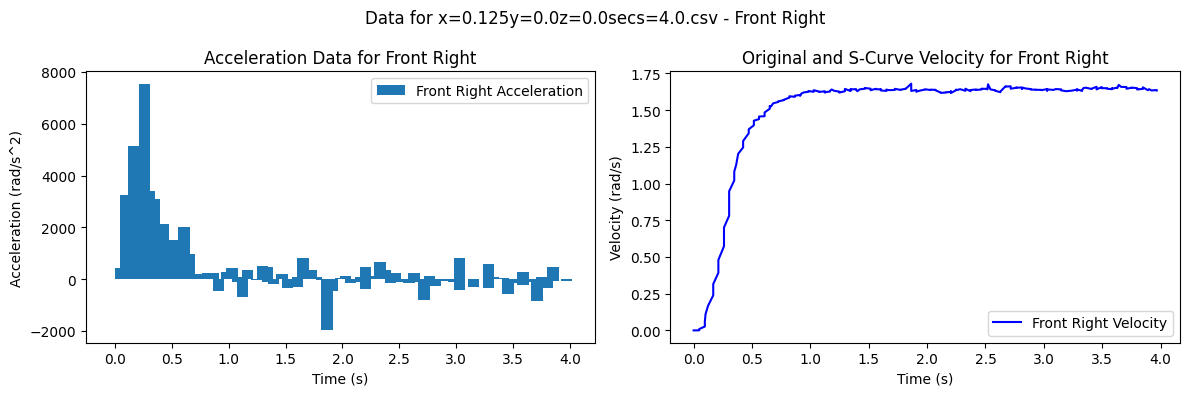

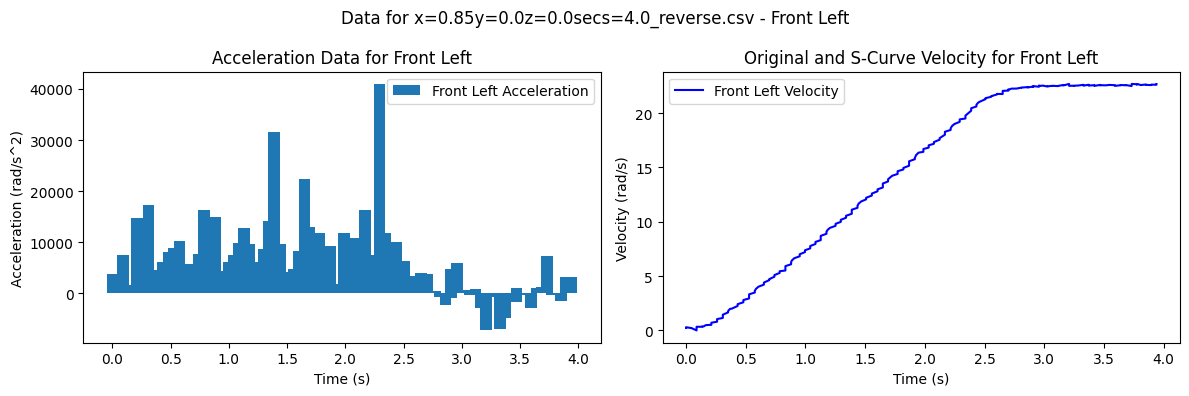

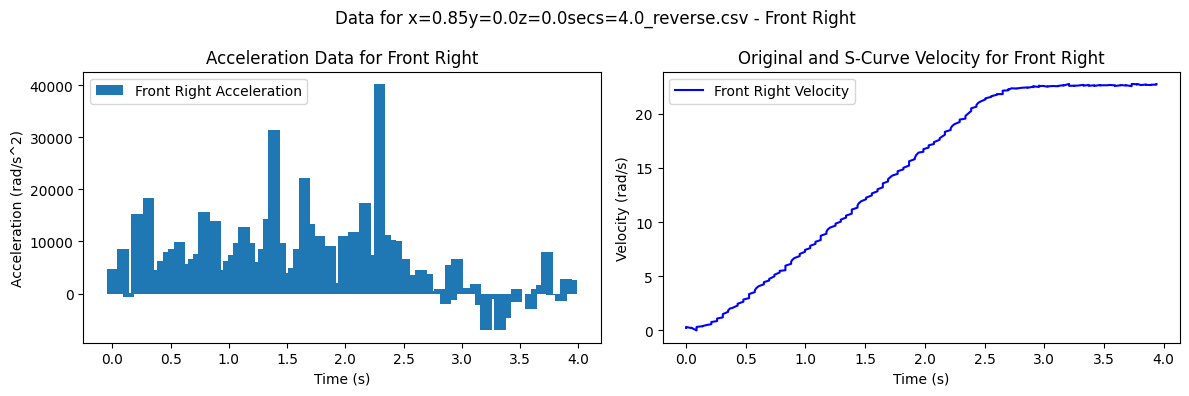

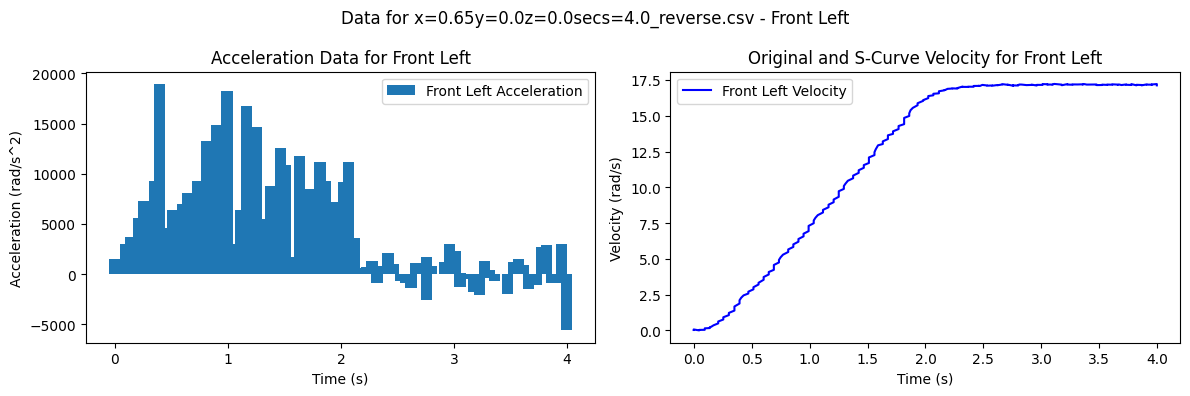

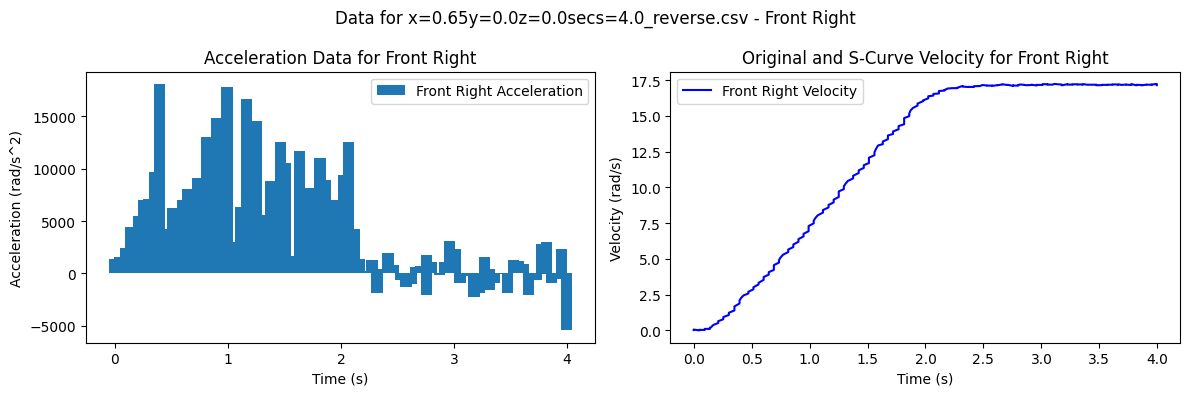

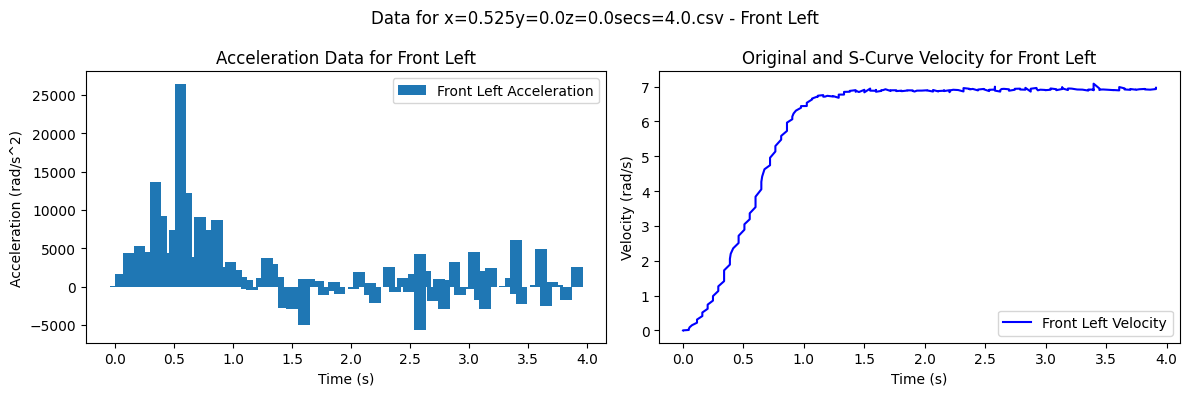

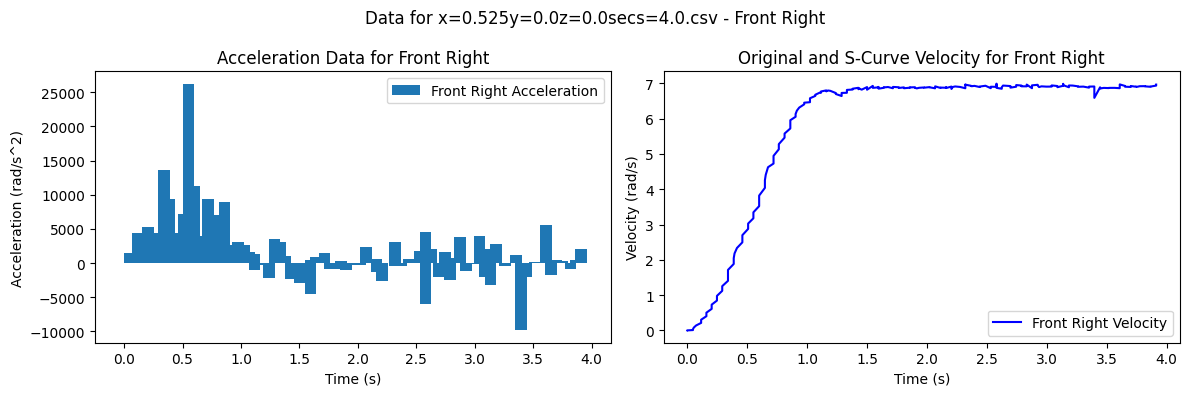

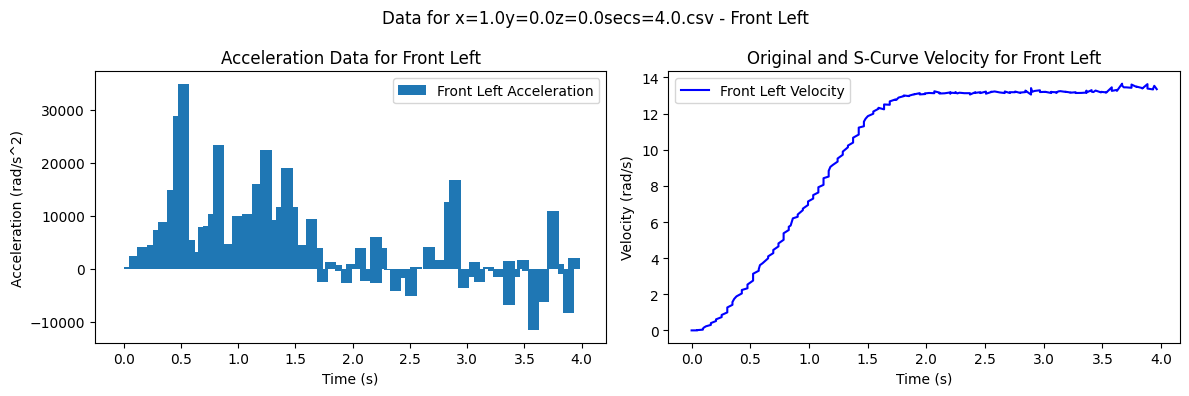

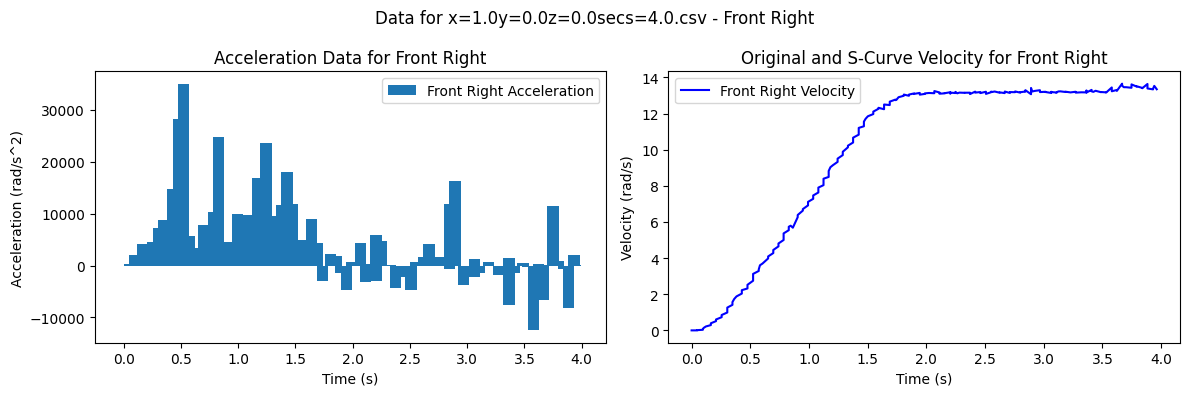

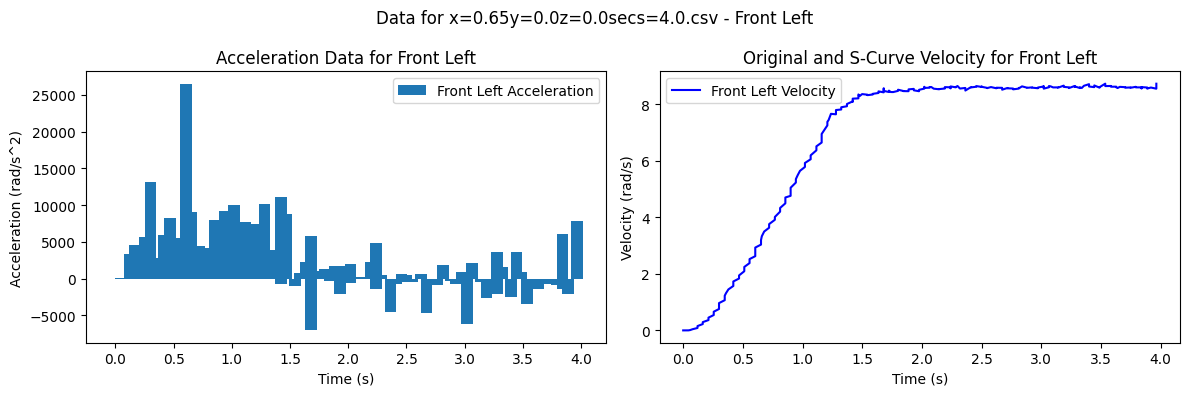

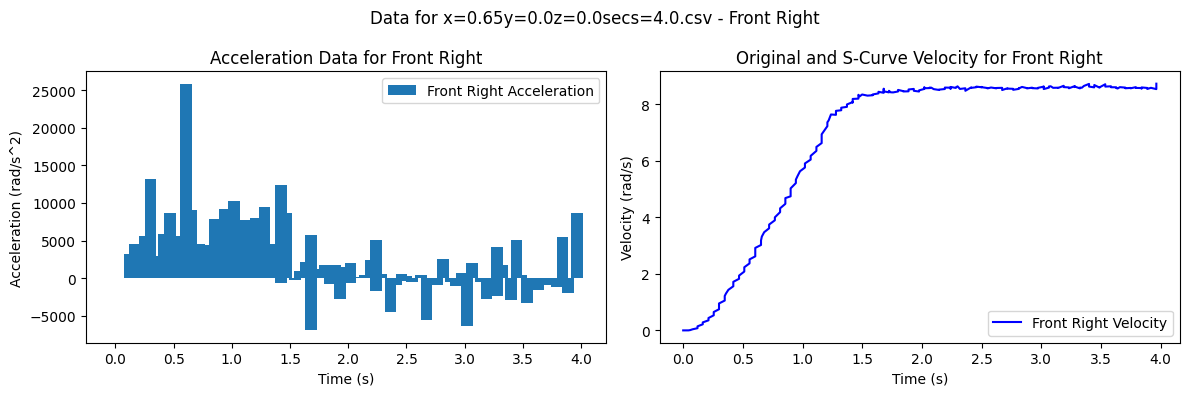

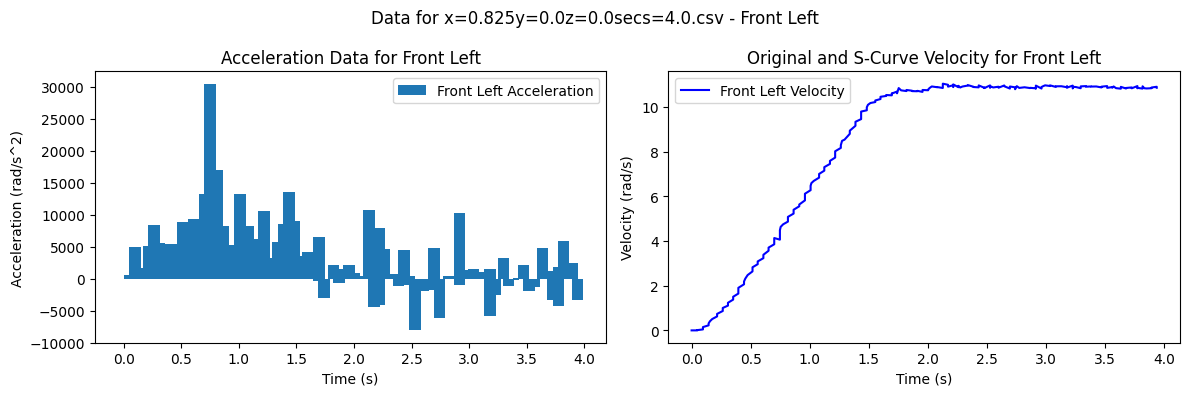

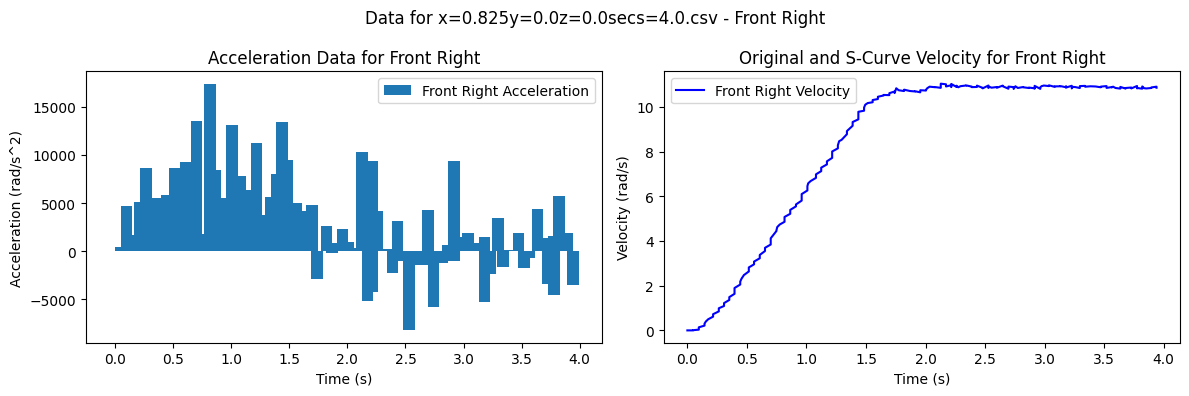

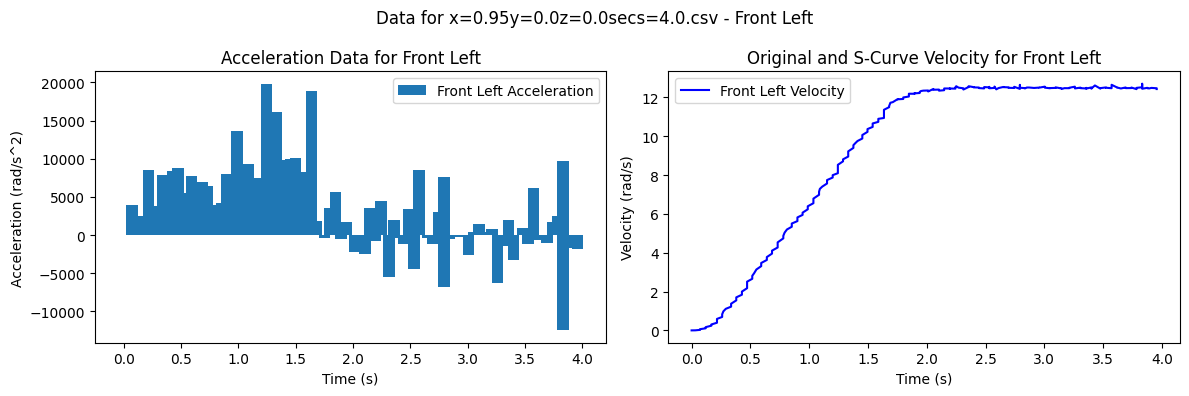

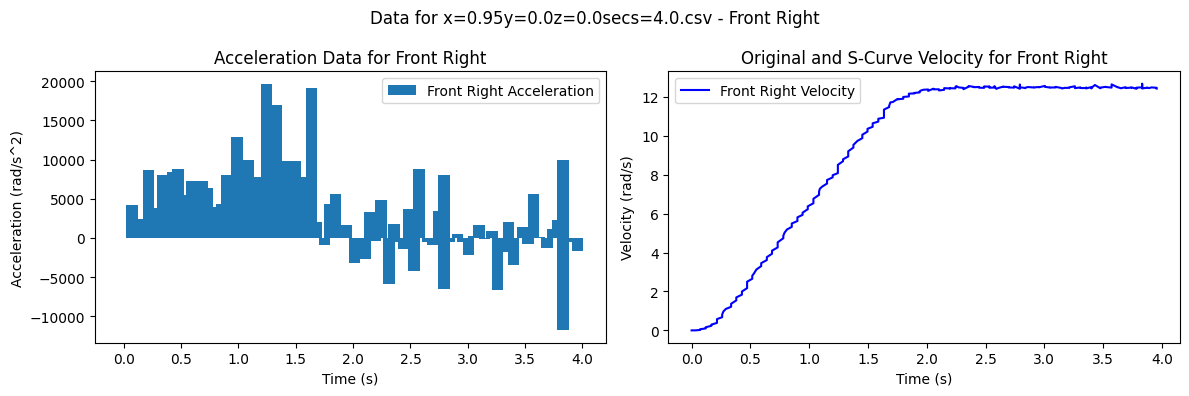

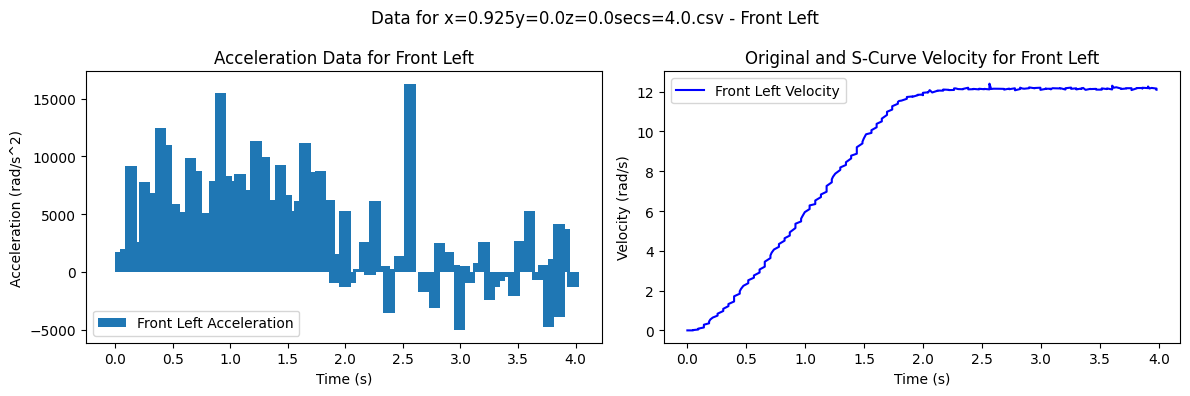

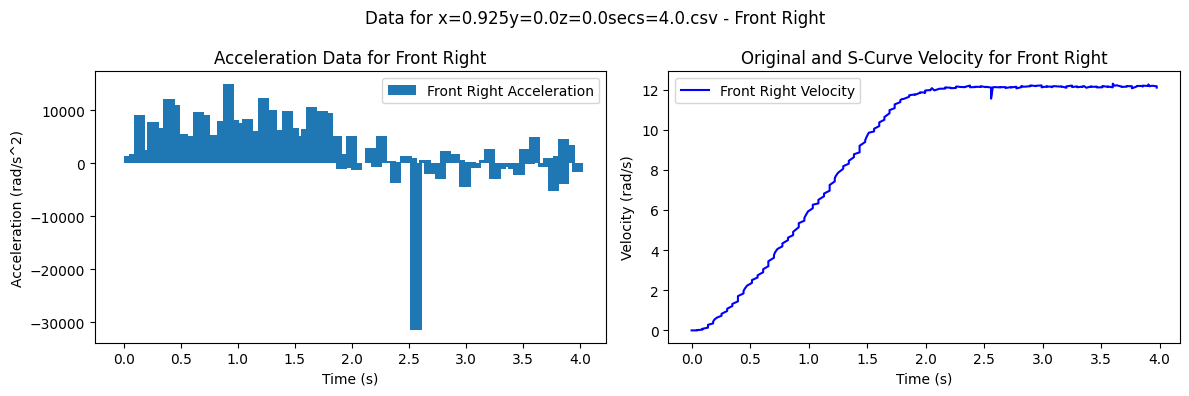

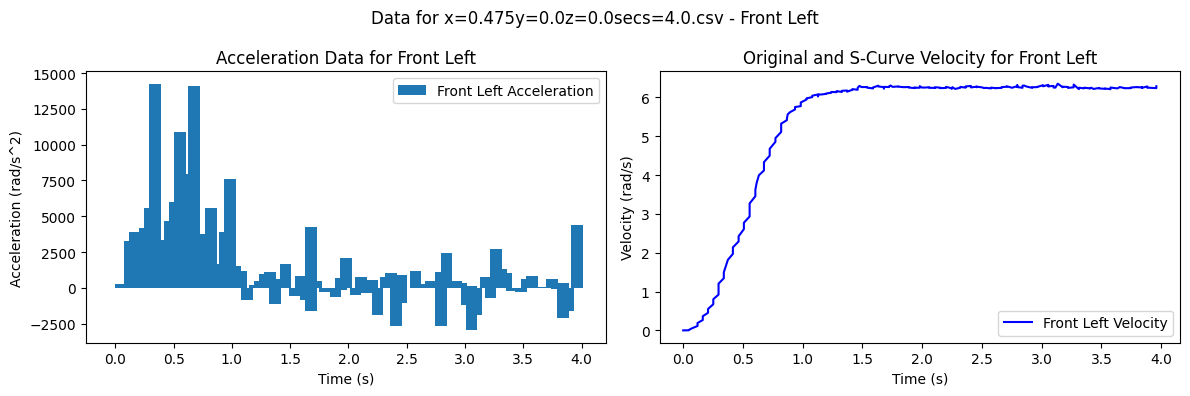

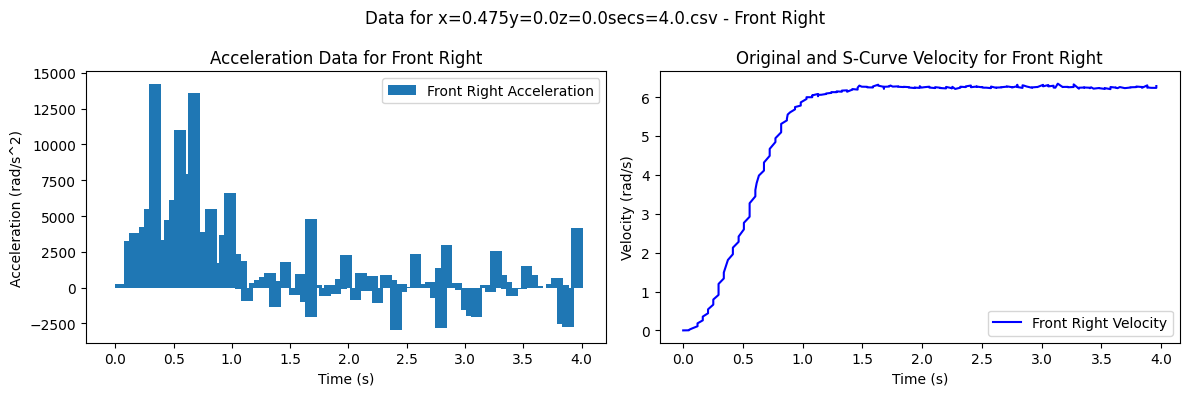

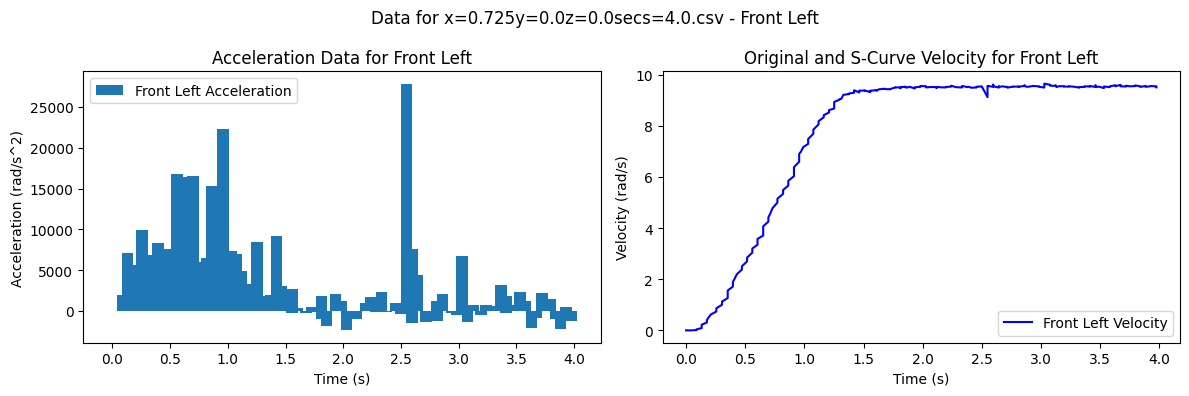

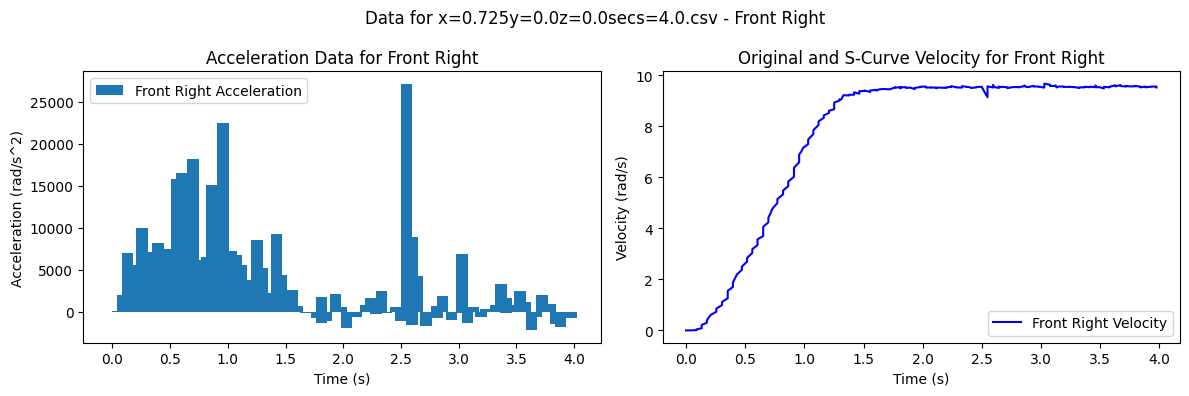

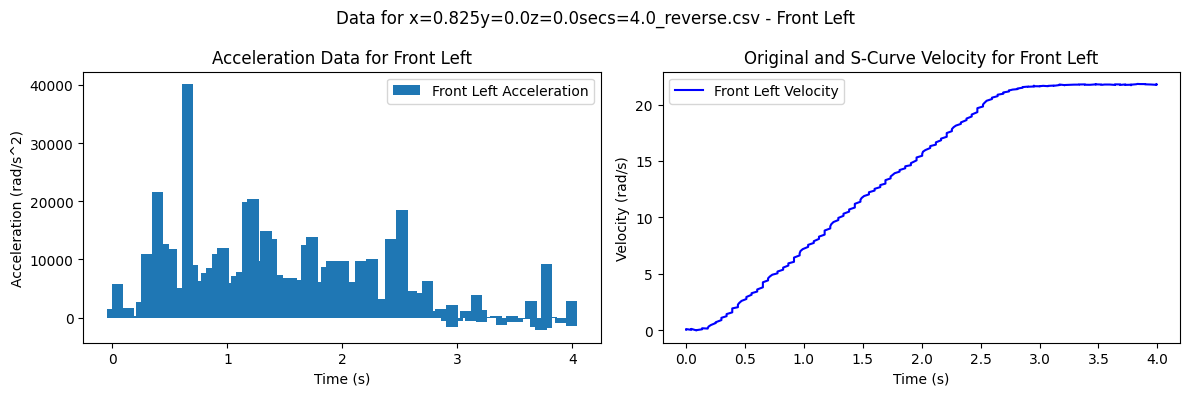

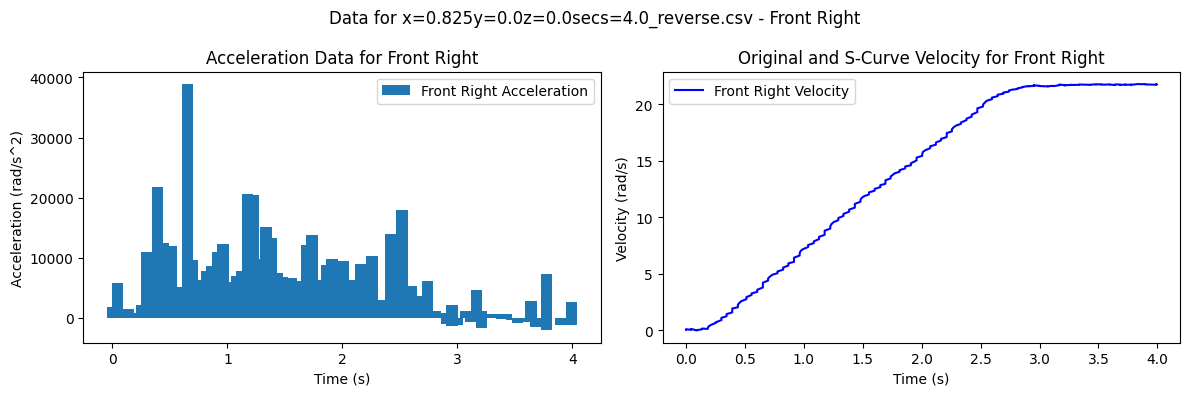

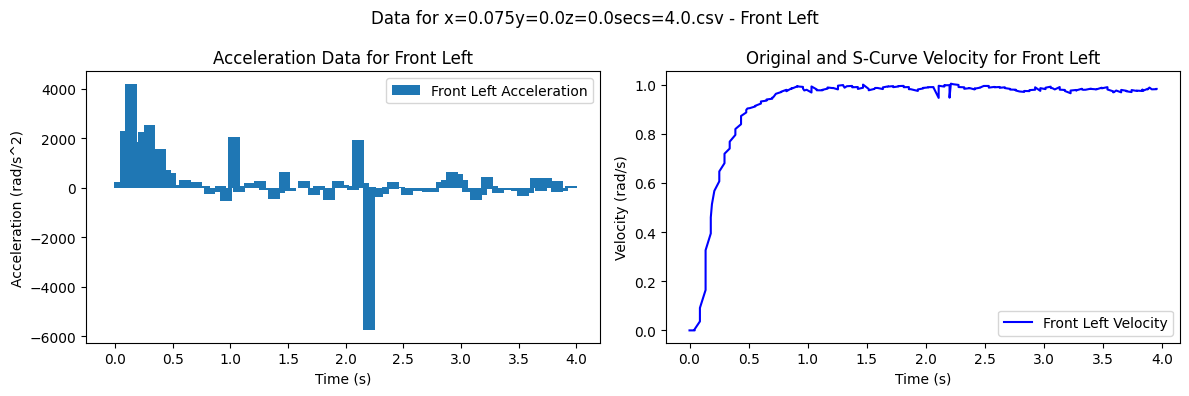

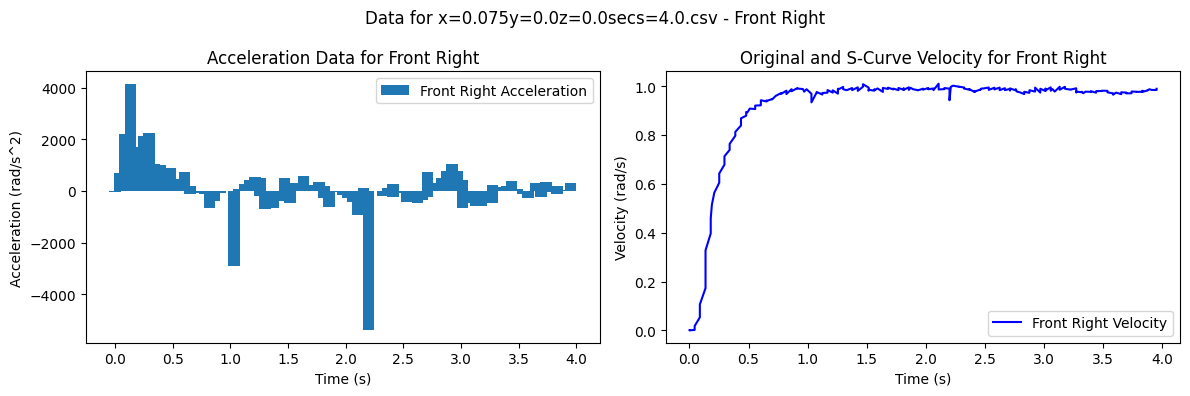

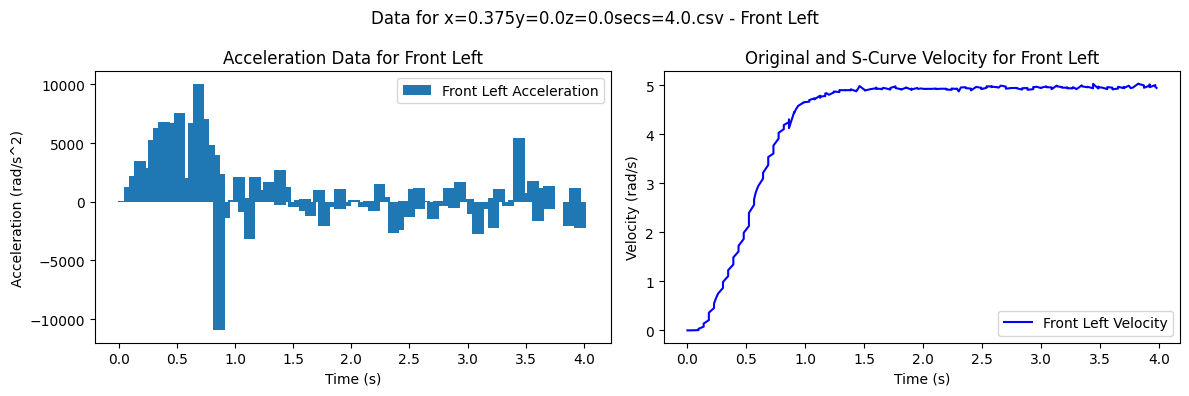

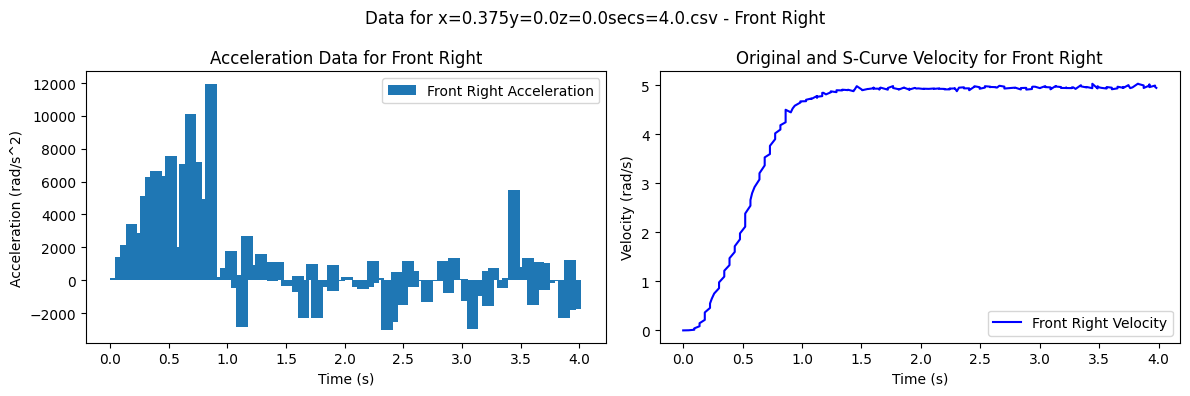

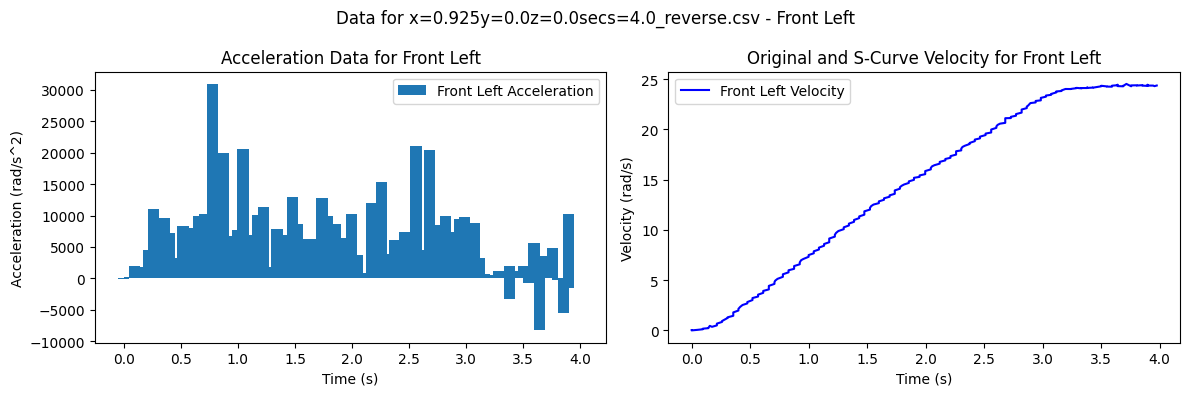

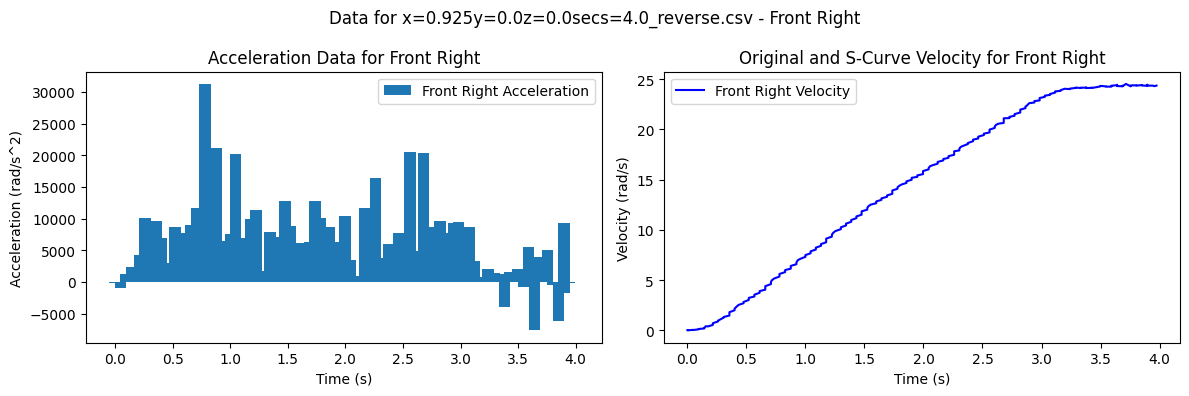

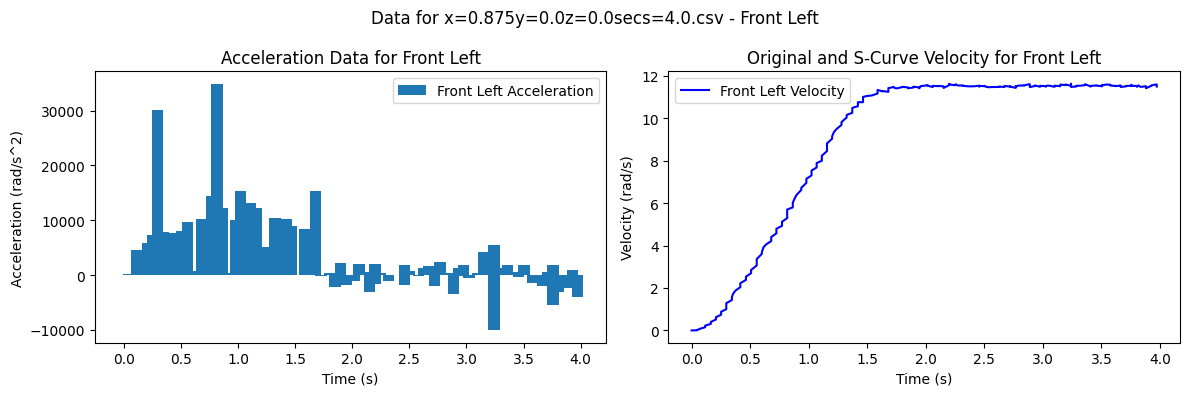

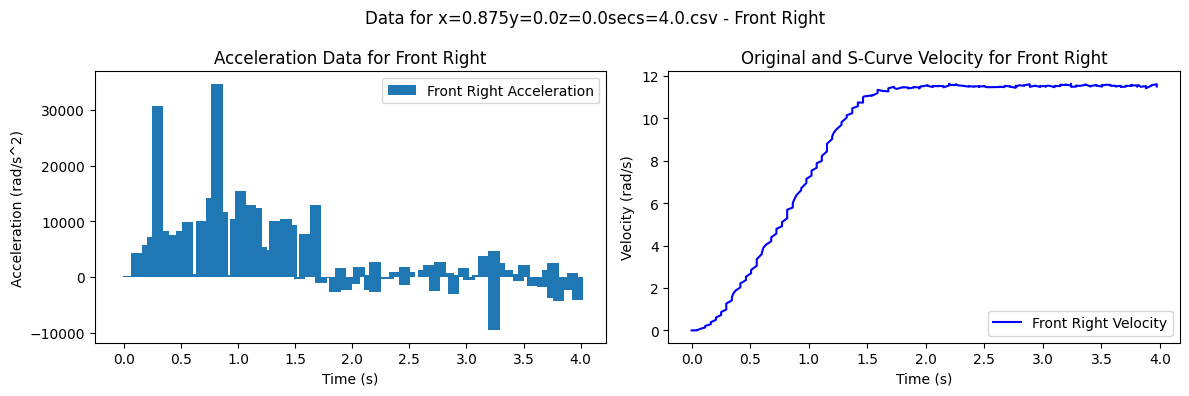

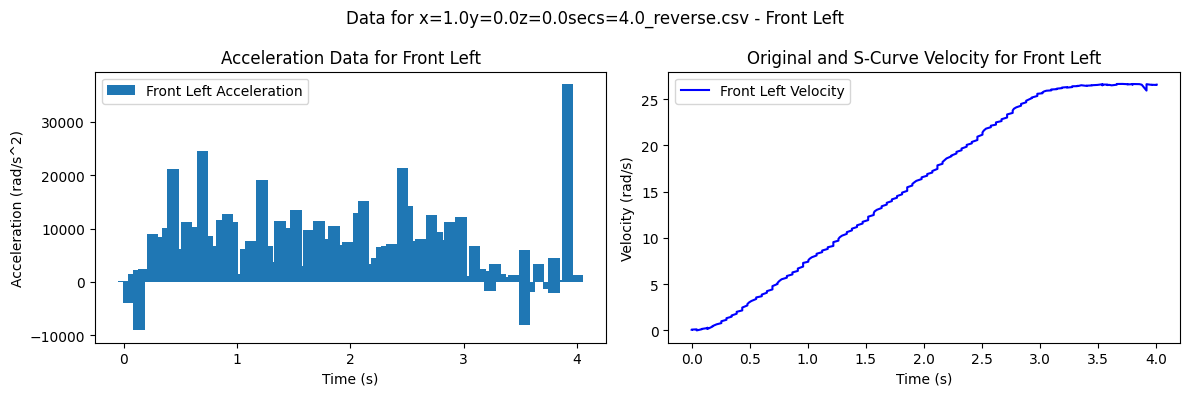

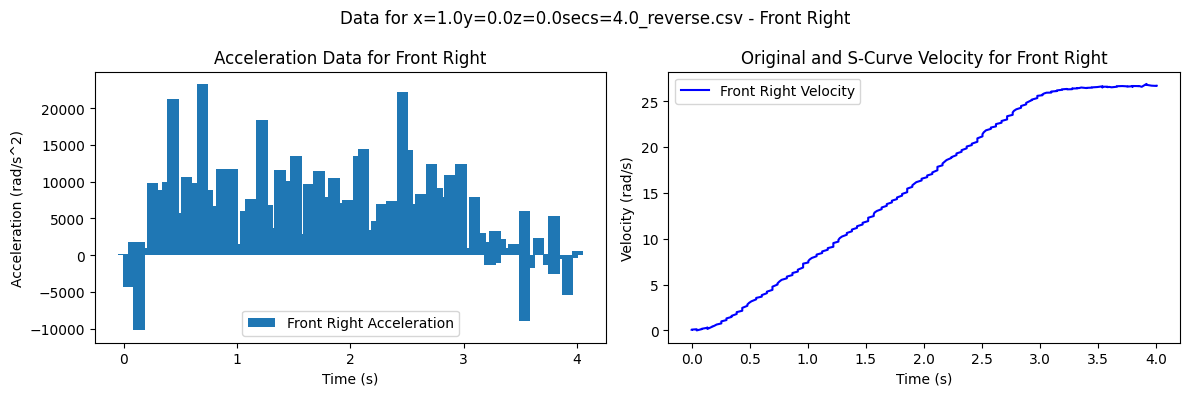

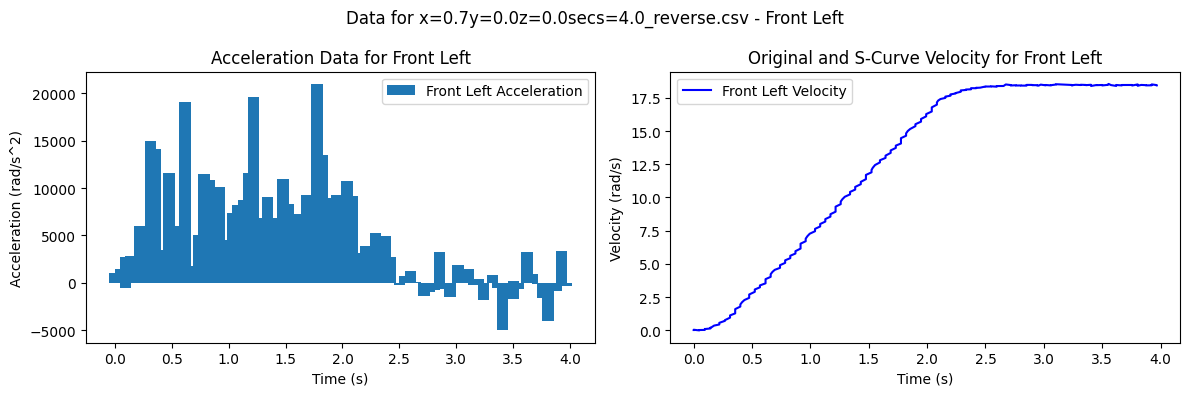

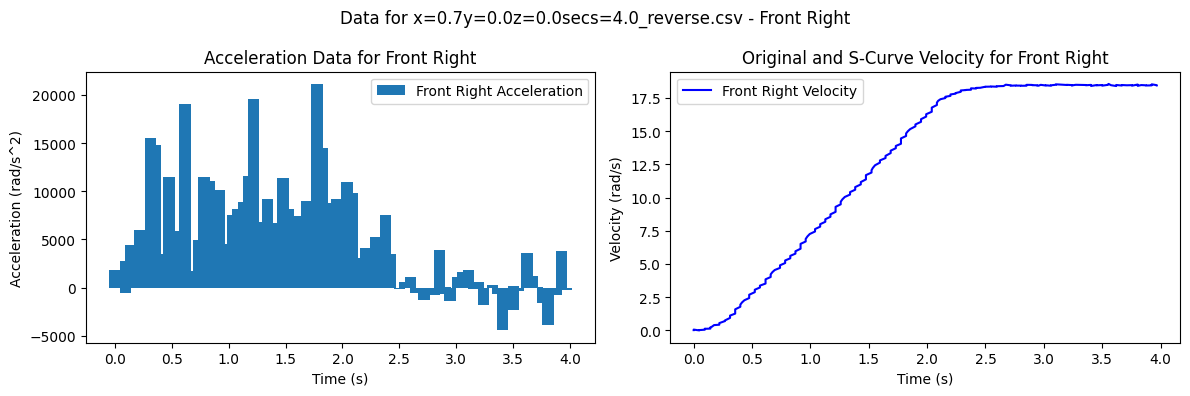

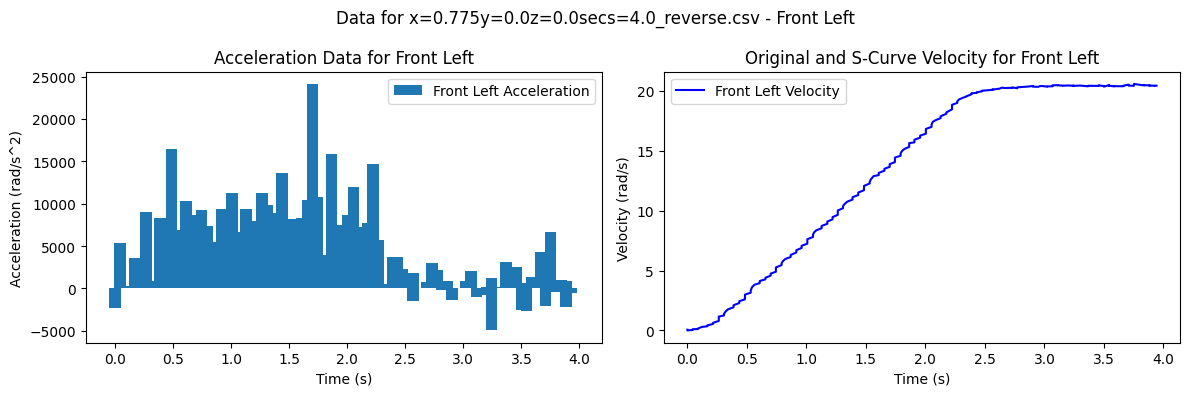

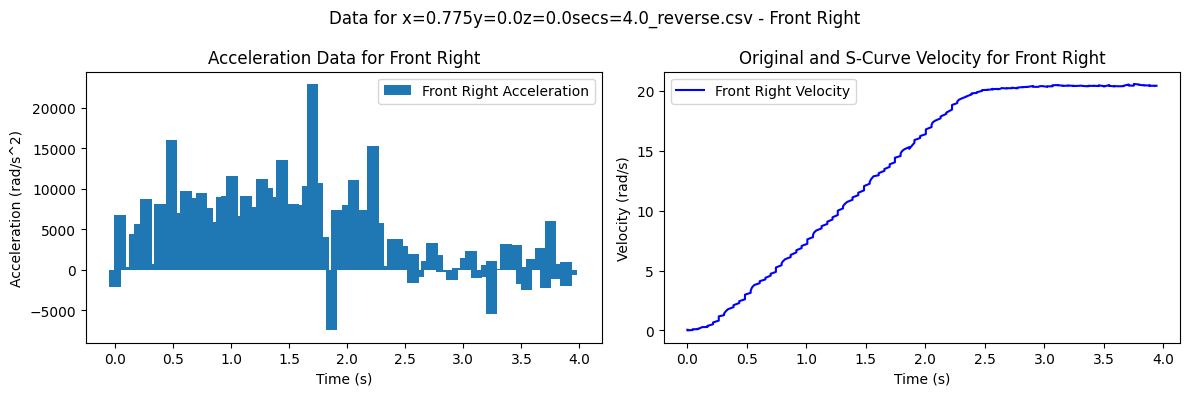

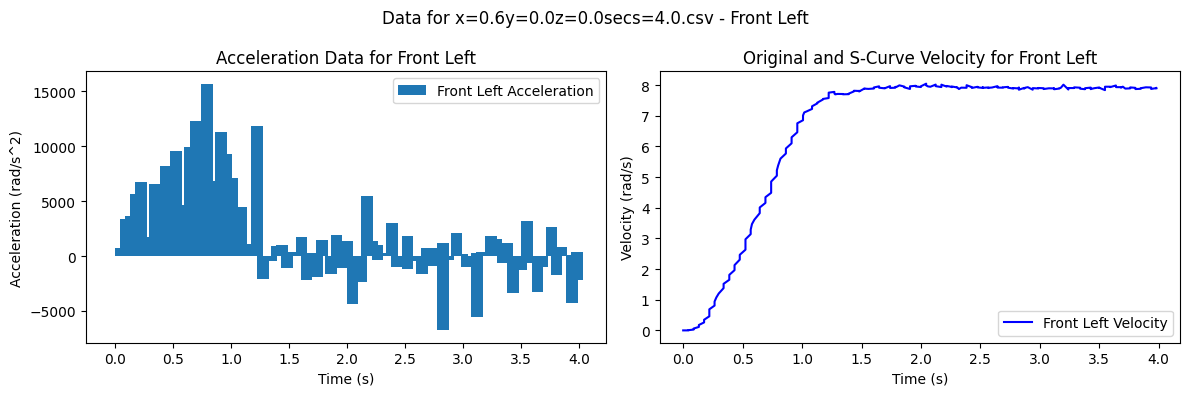

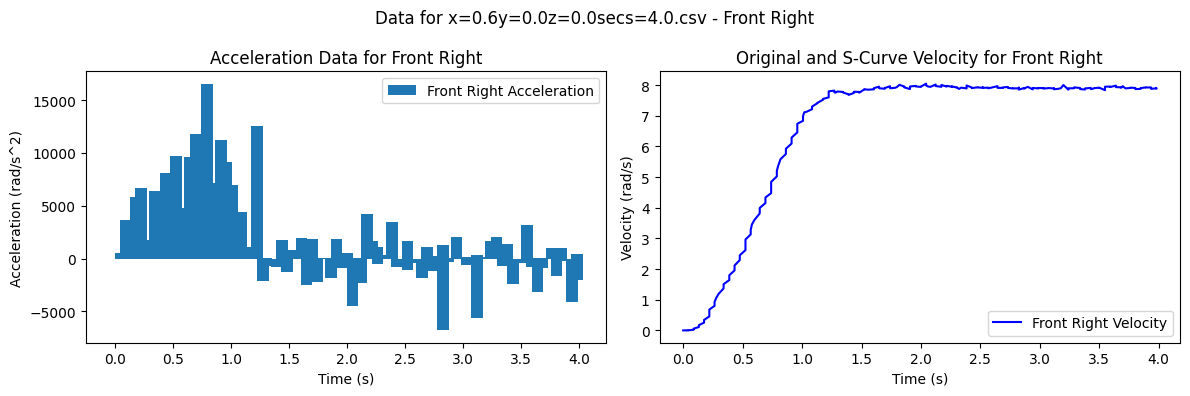

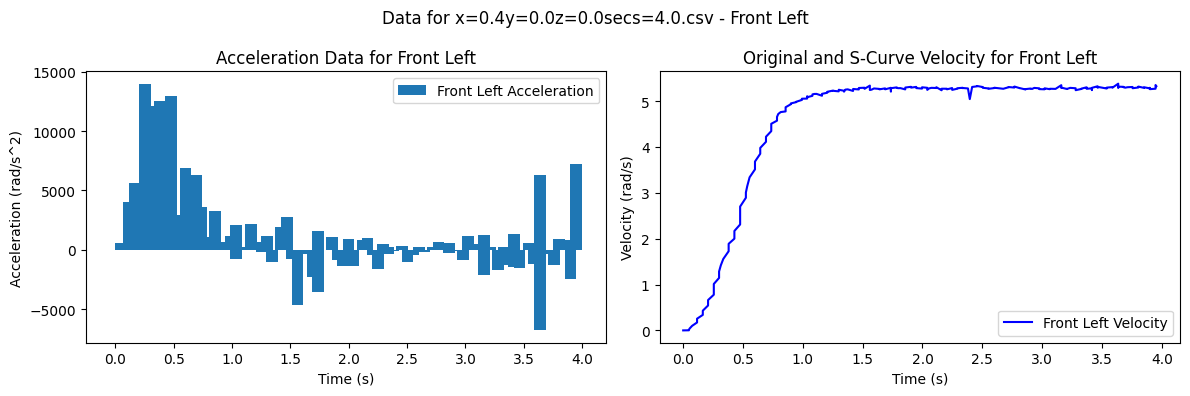

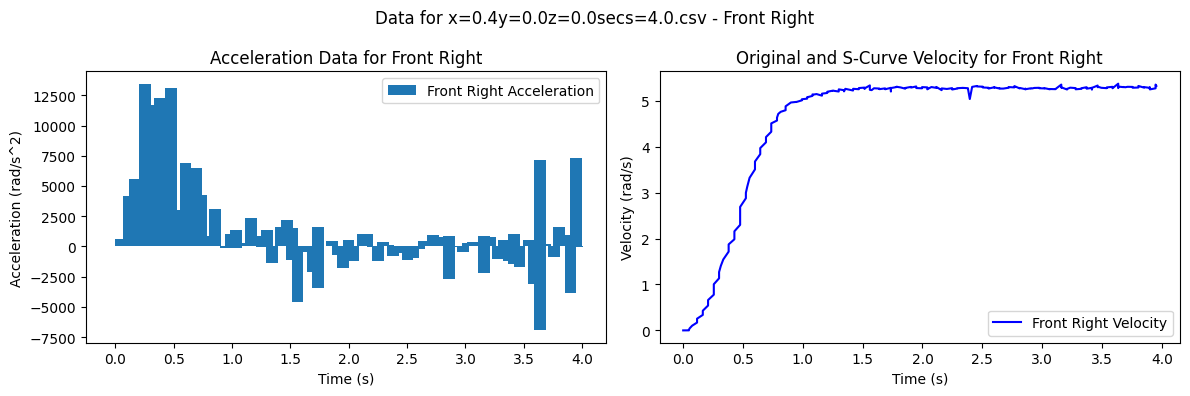

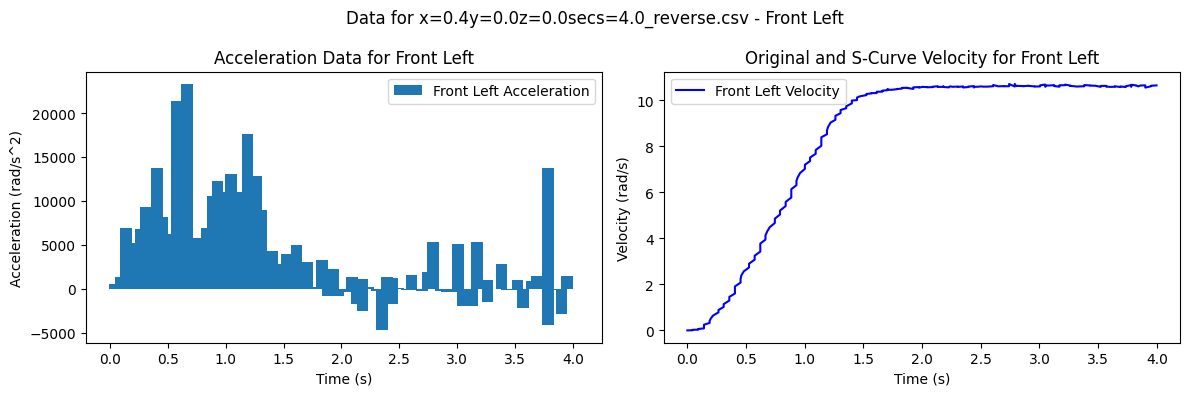

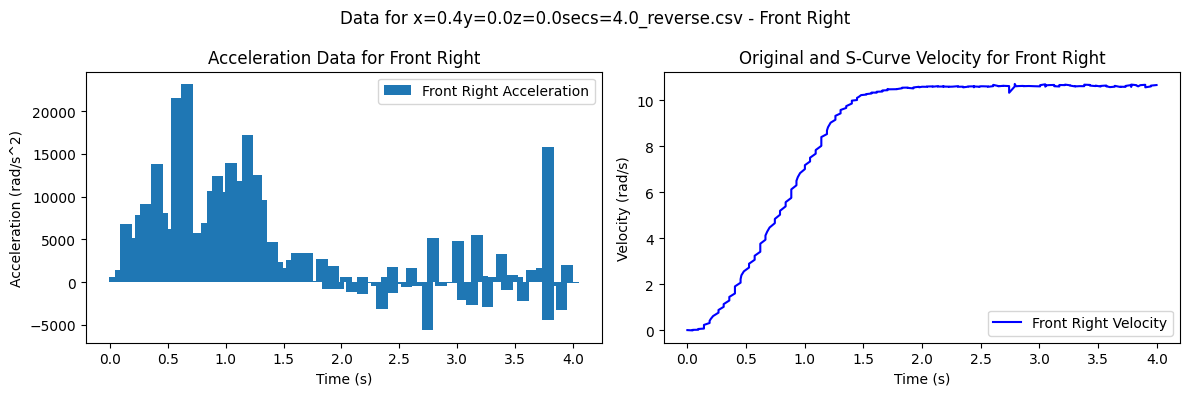

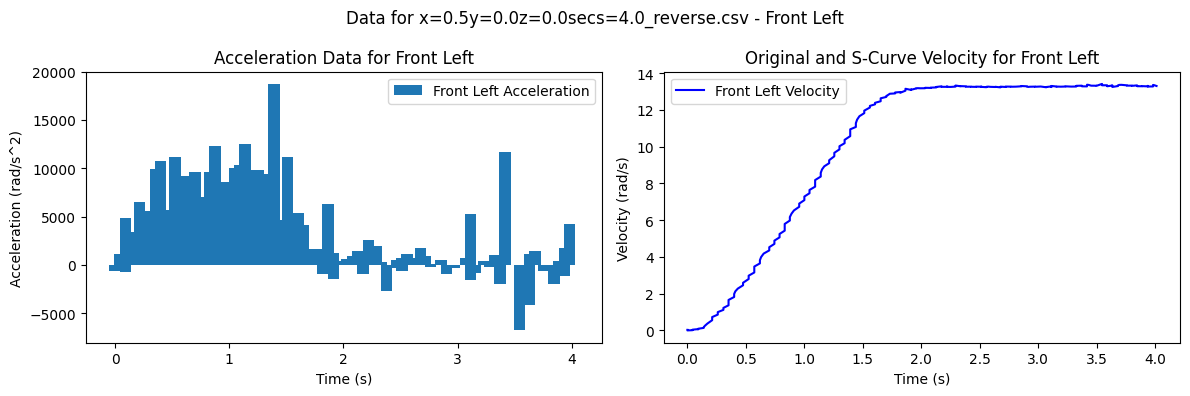

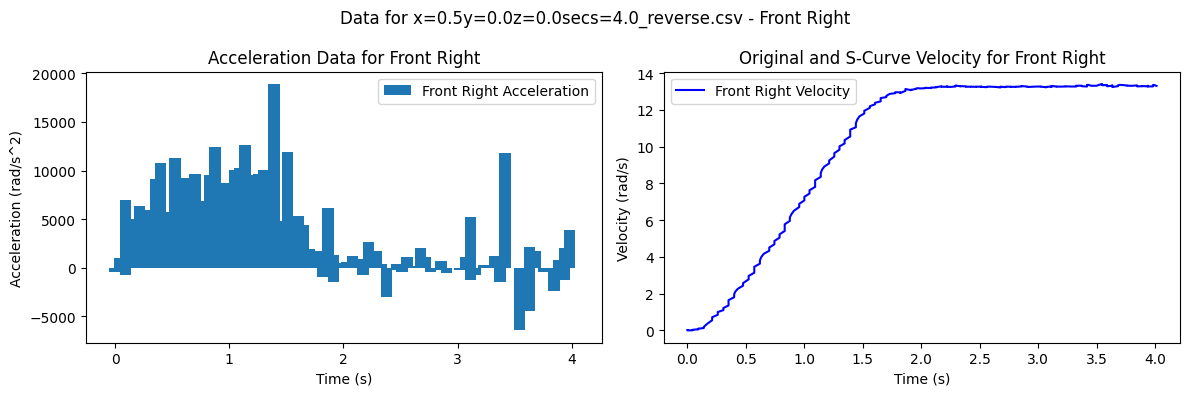

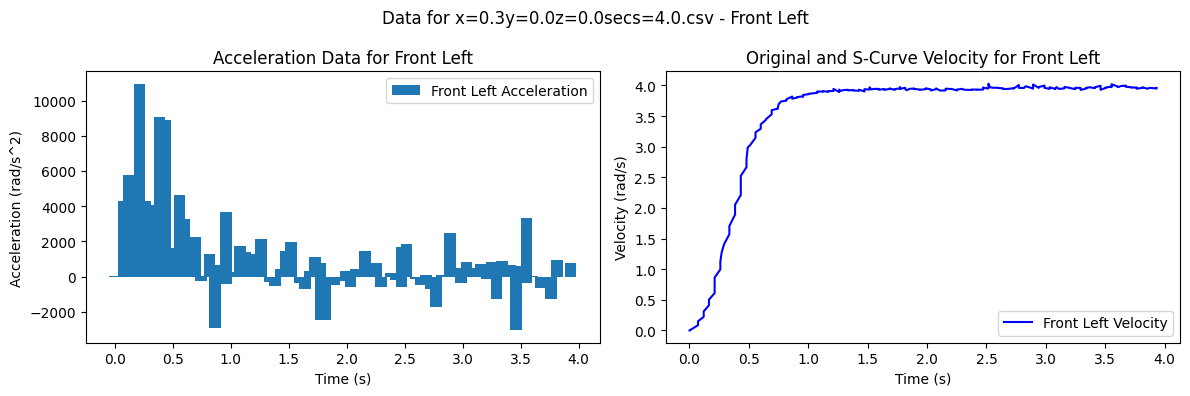

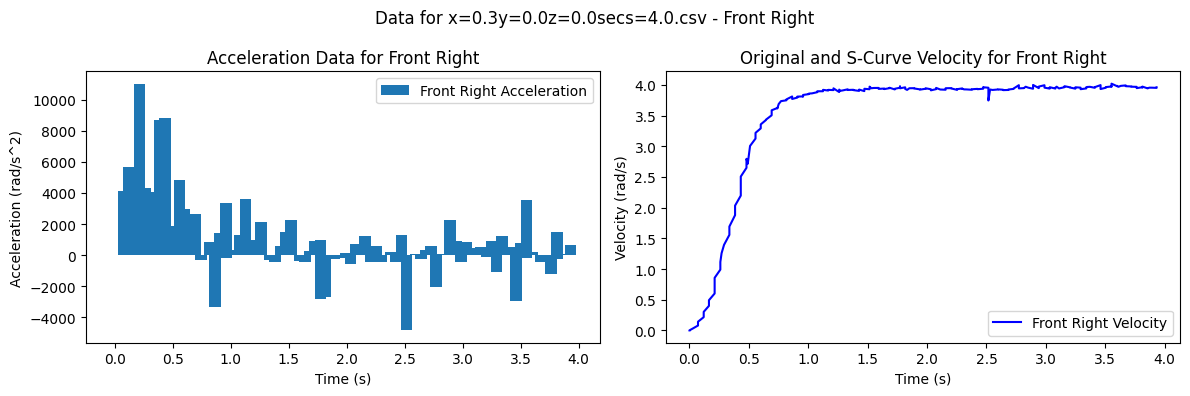

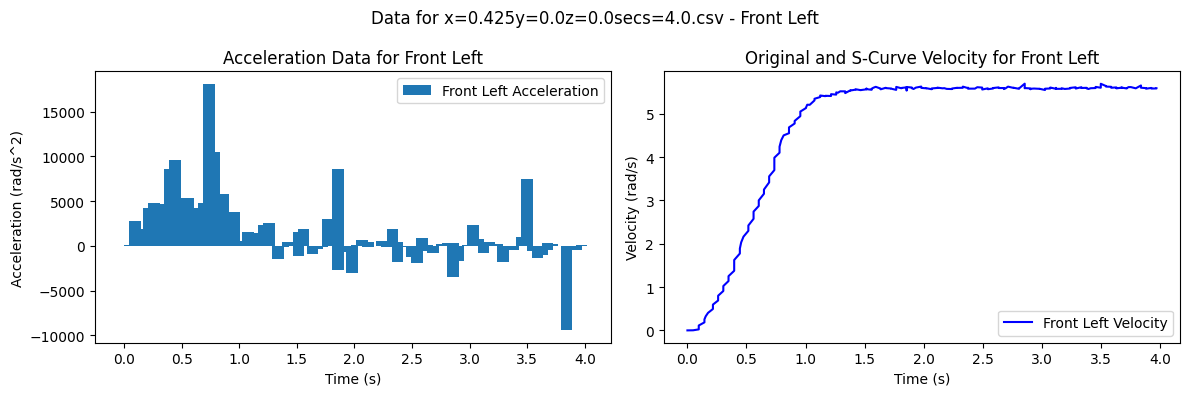

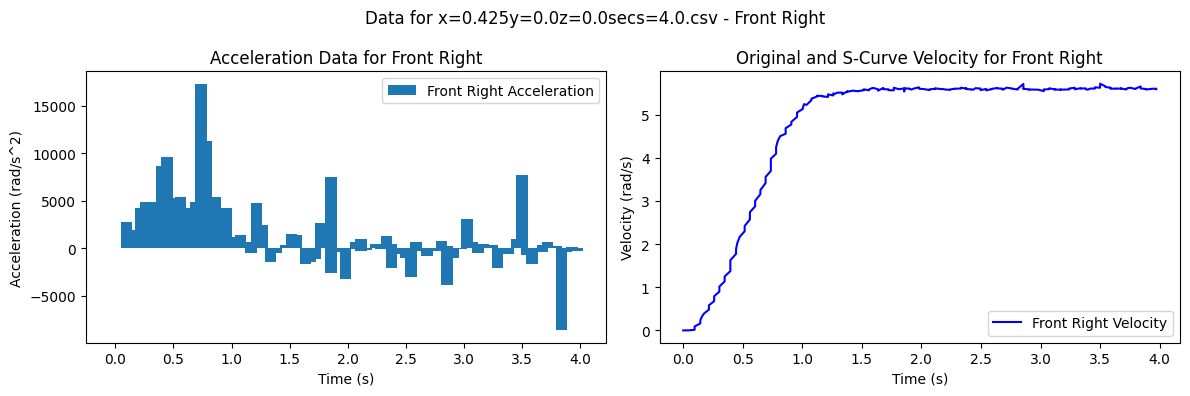

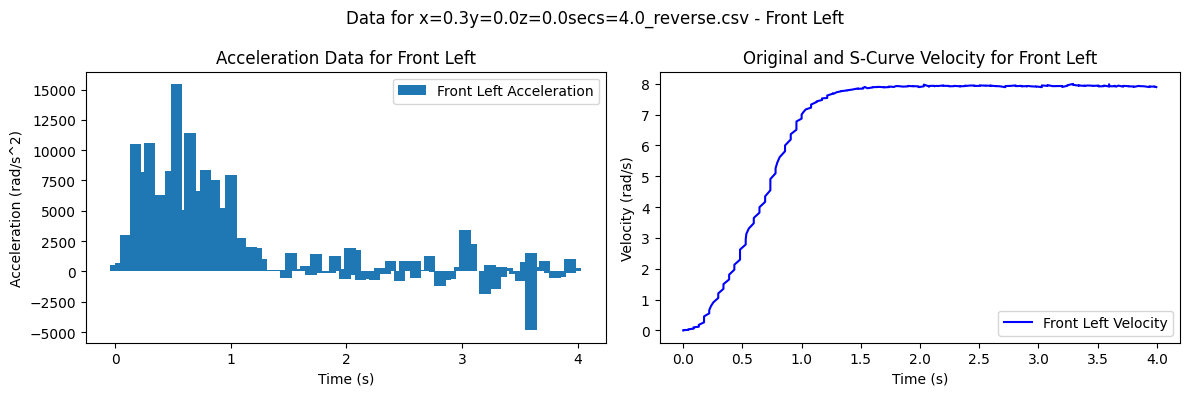

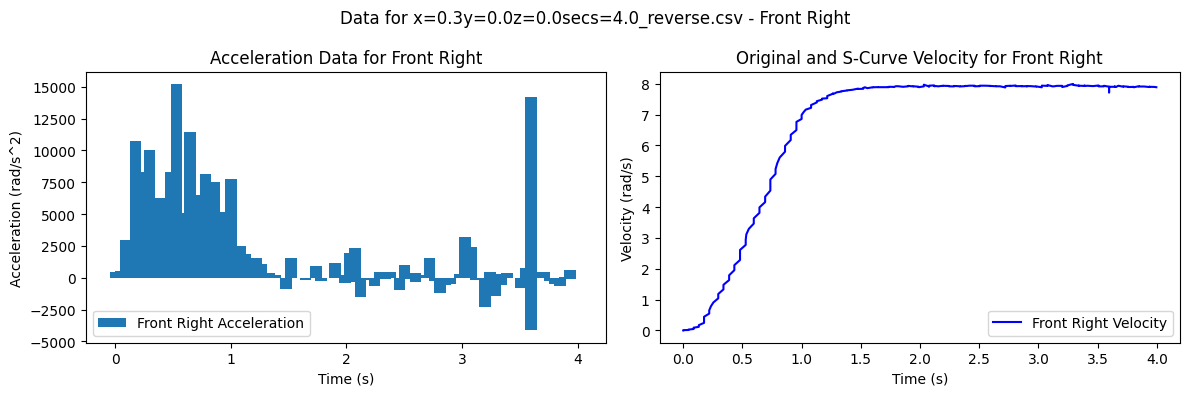

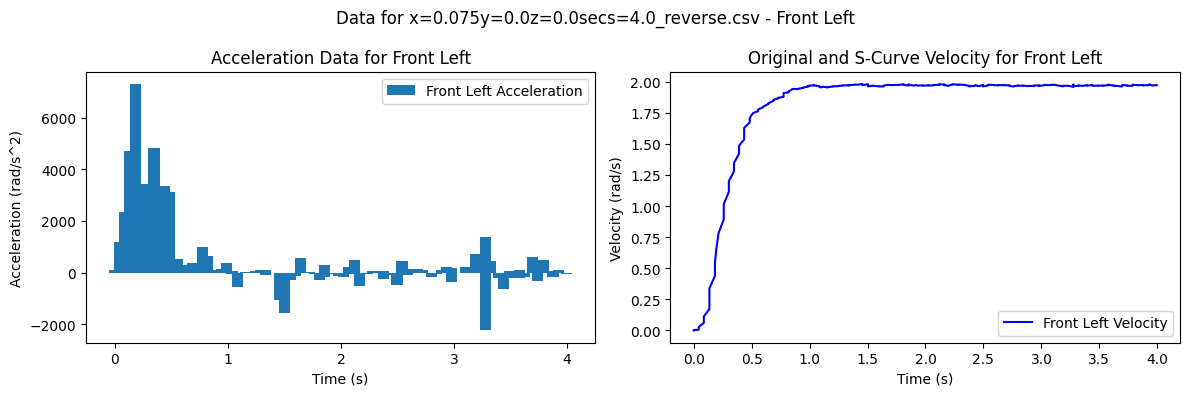

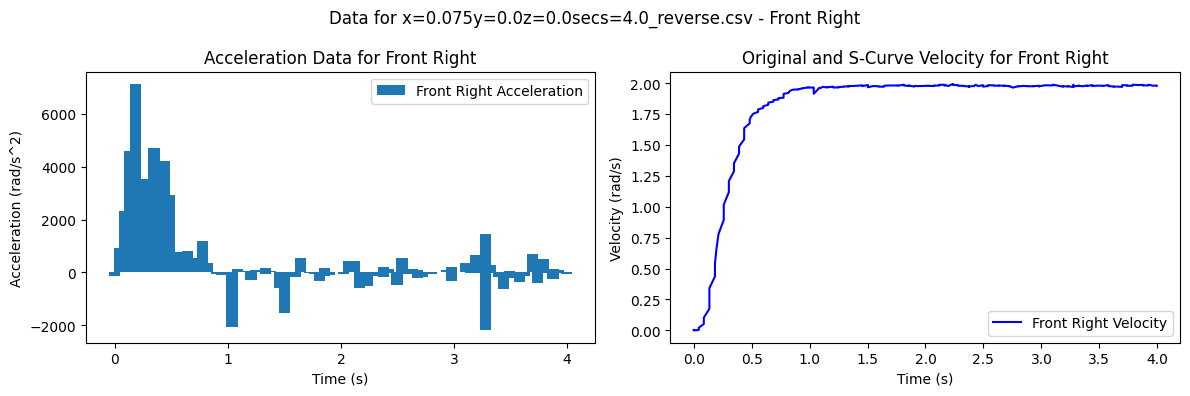

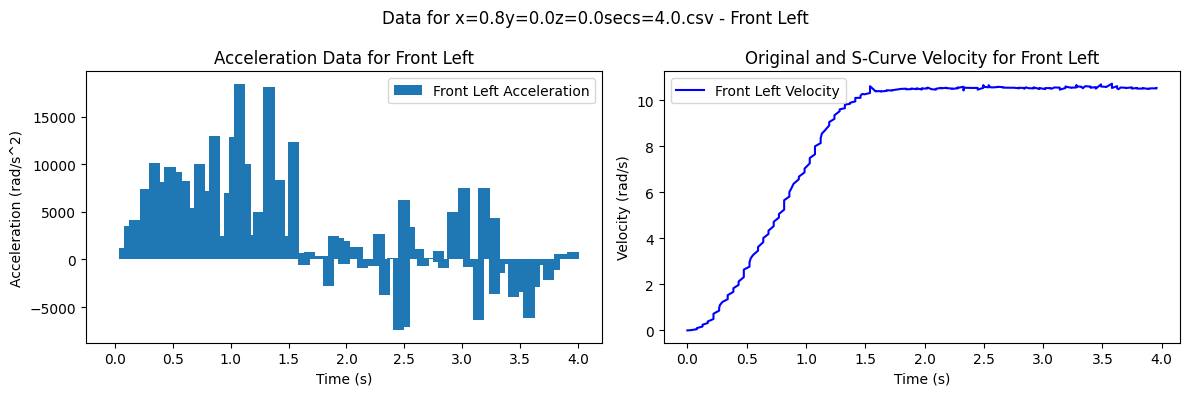

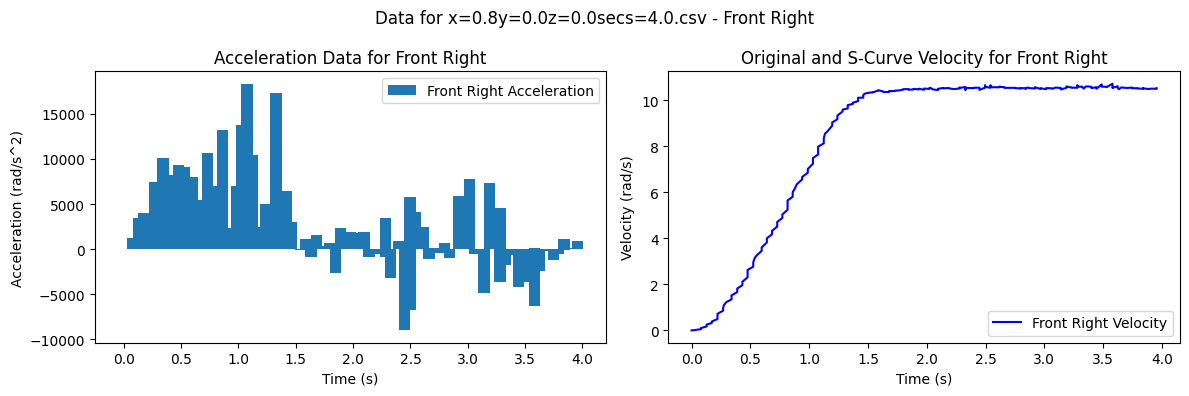

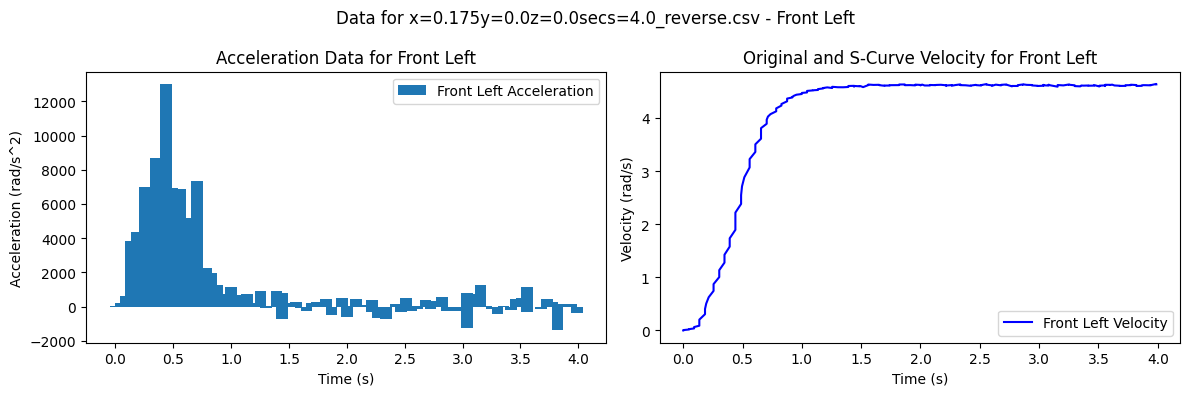

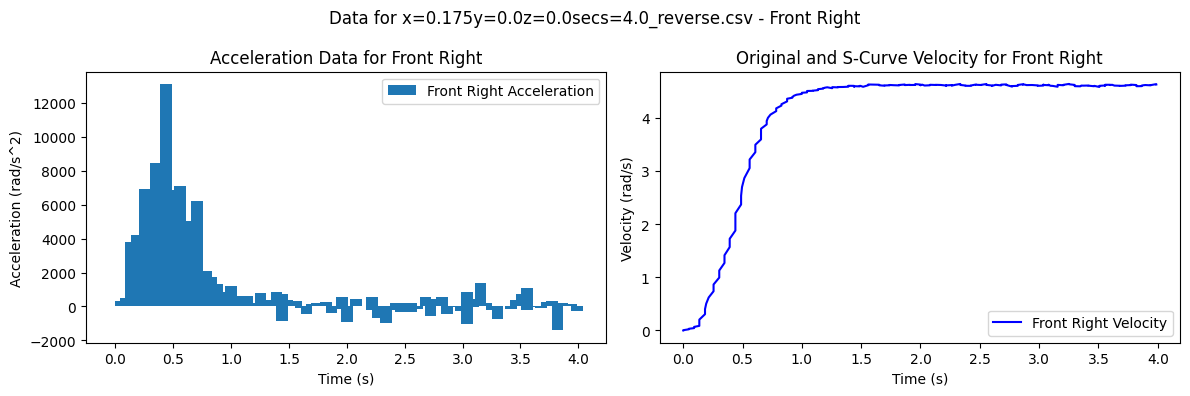

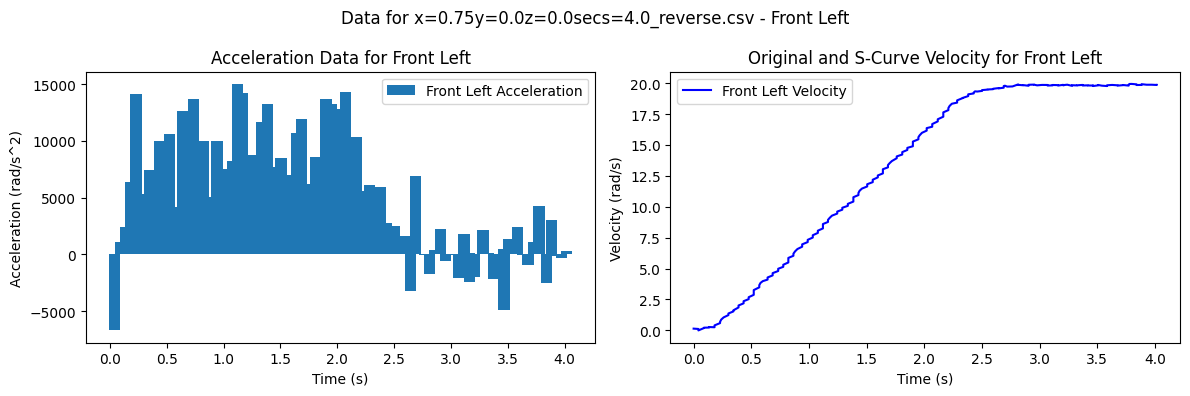

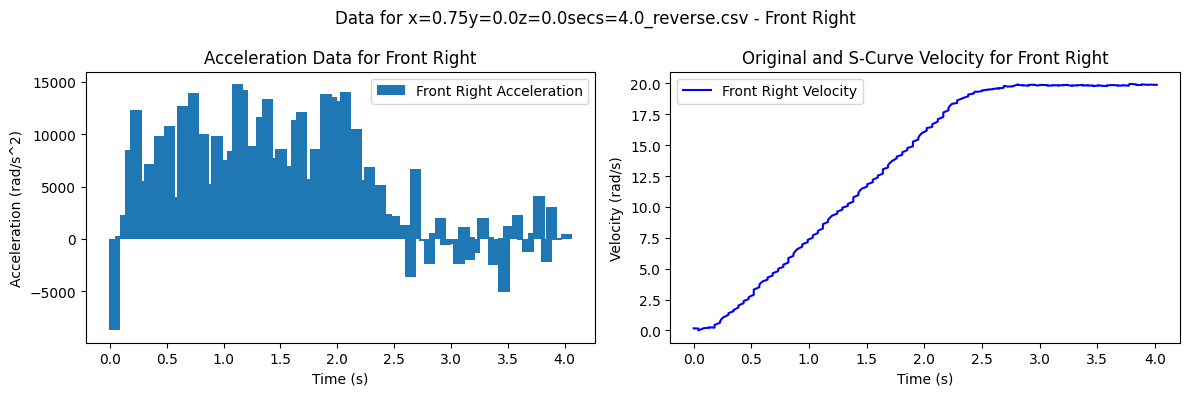

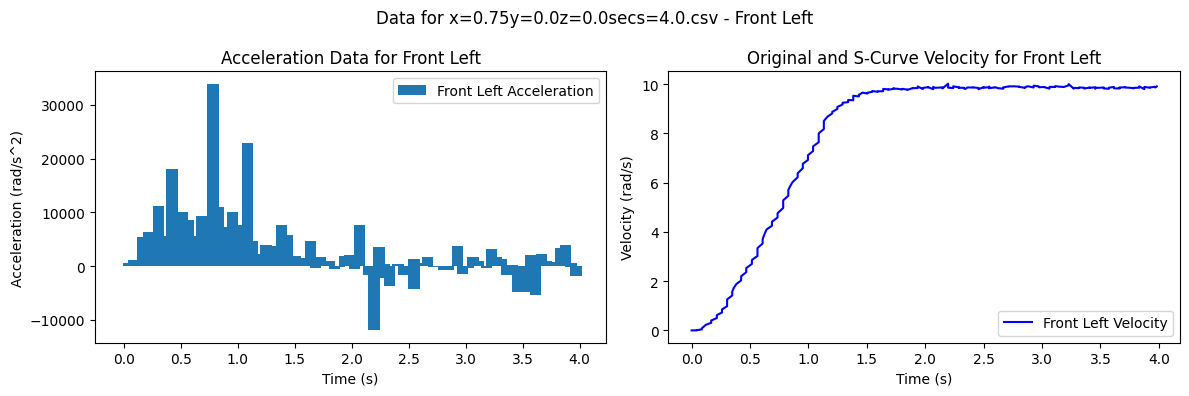

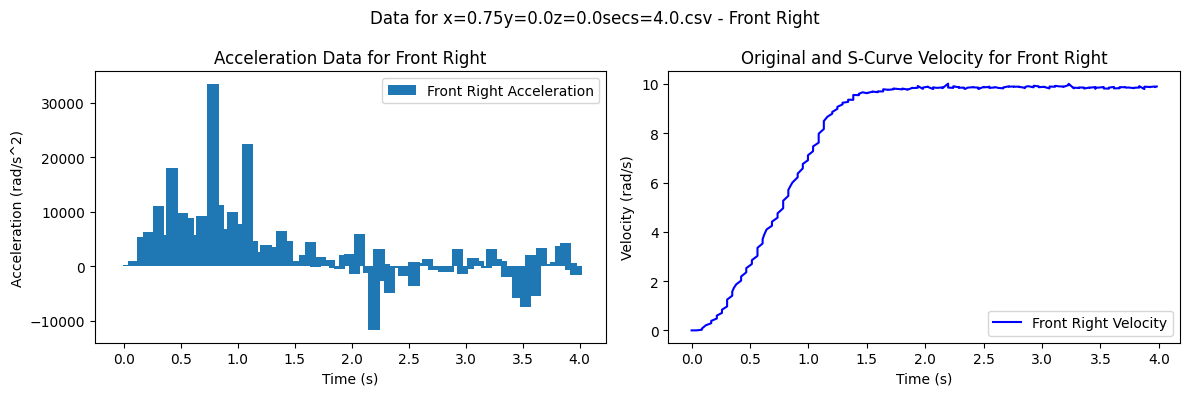

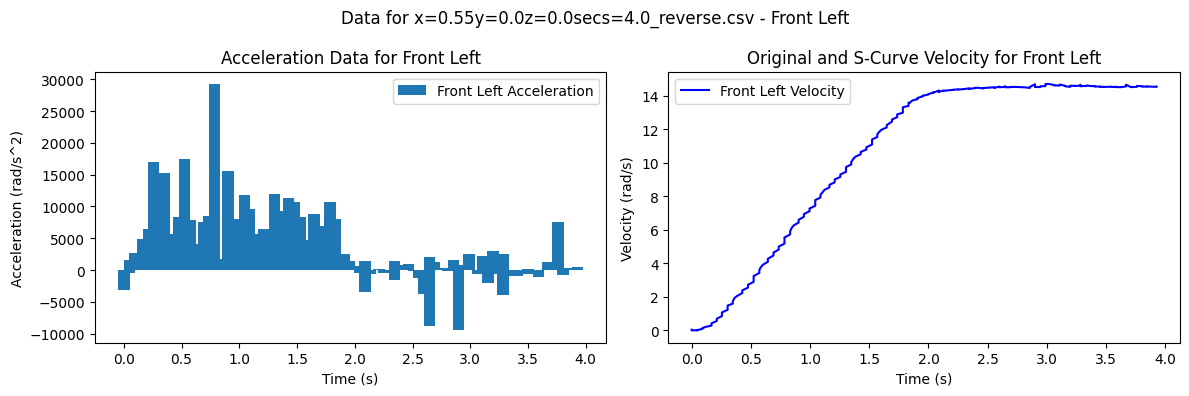

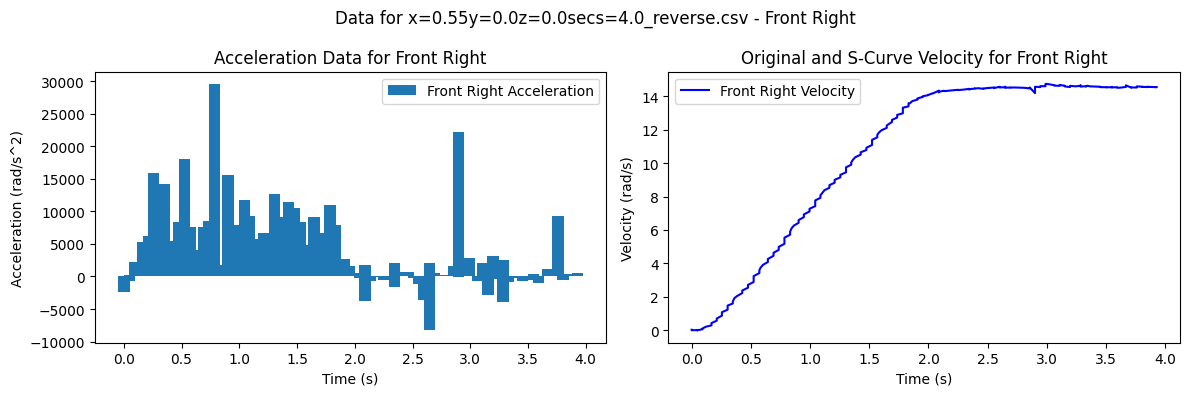

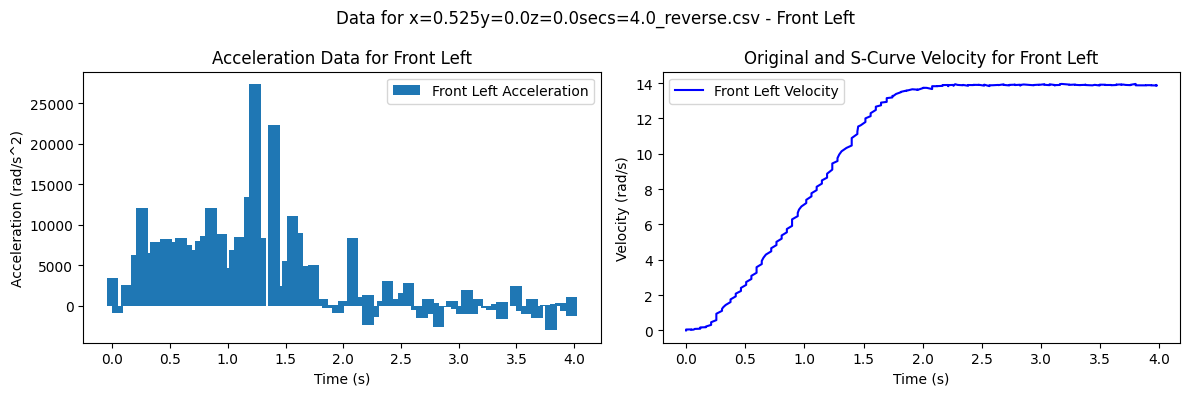

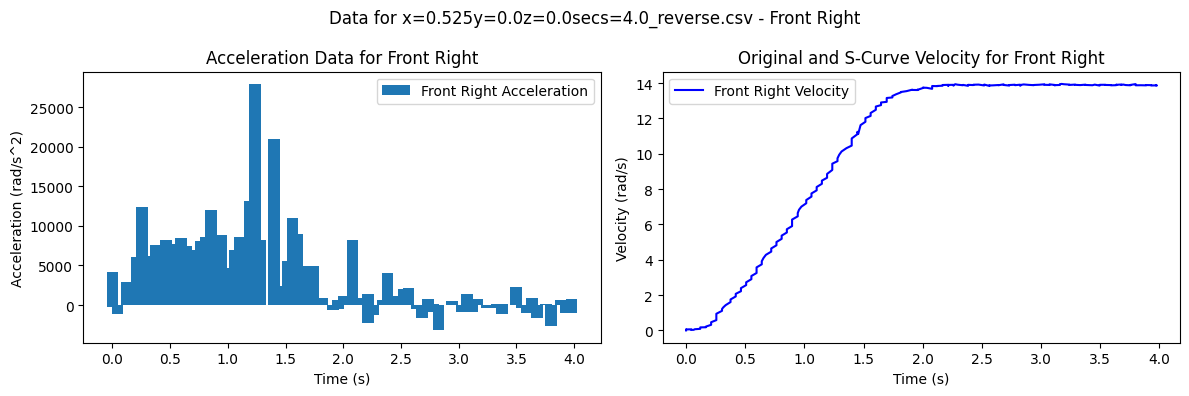

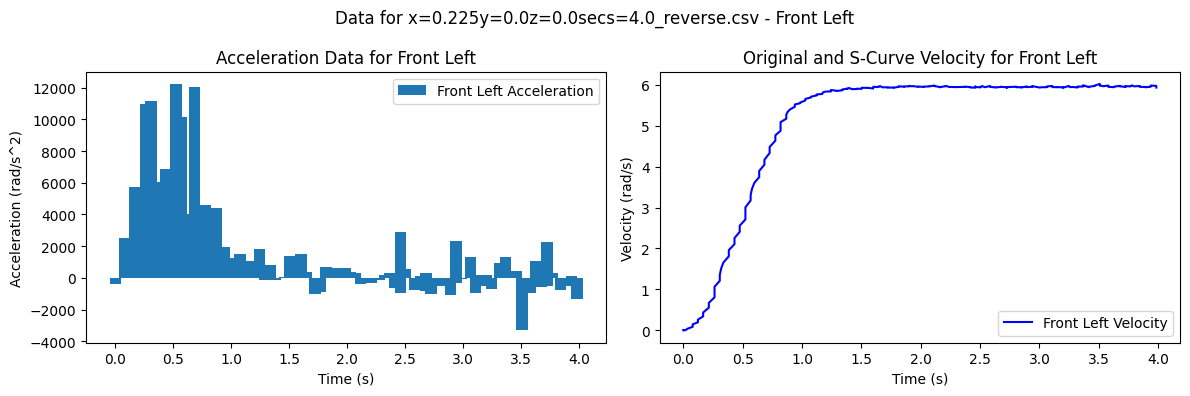

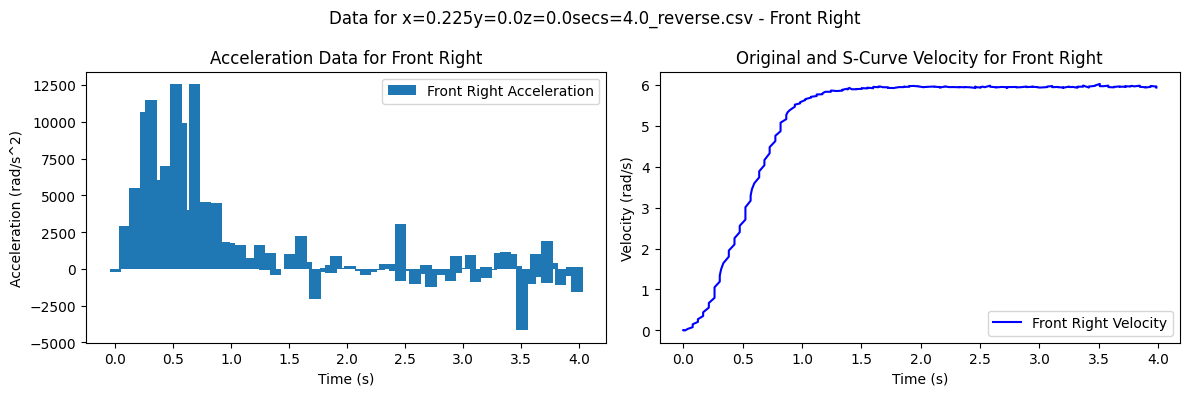

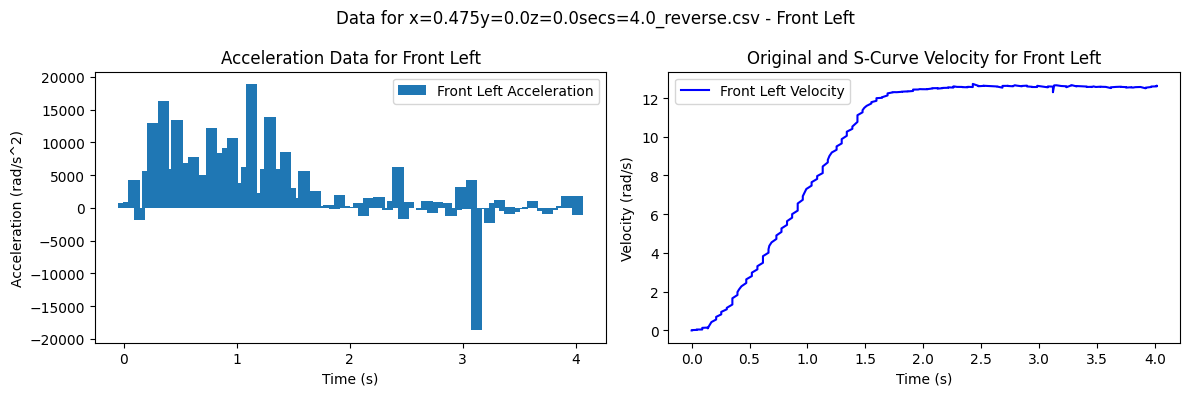

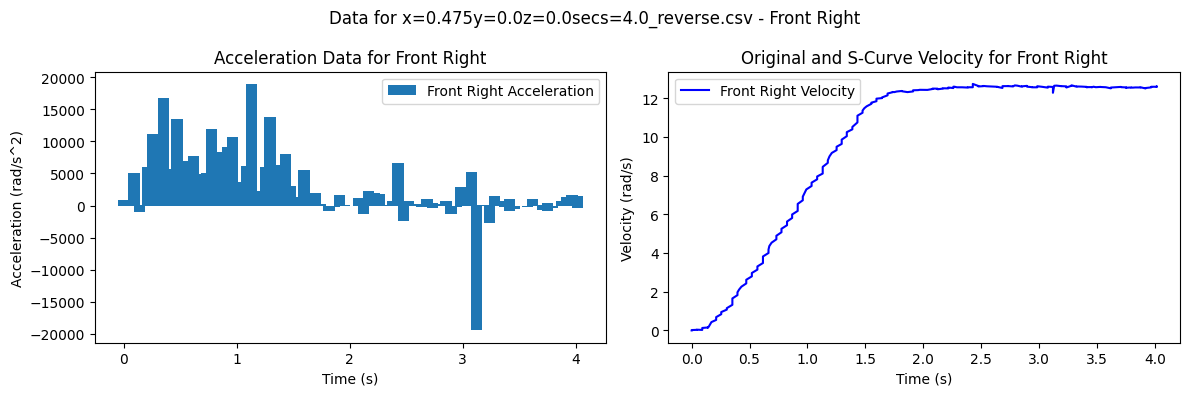

In [3]:
import os
import pandas as pd
import numpy as np
import random
from scipy.signal import convolve
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import numpy as np

threshold = 0.99


def process_velocities(wheel_data):
    return np.abs(wheel_data - np.min(wheel_data))

# Directory containing the processed data folders
input_directory = "../../../trajectory_data/real/recordings/x"

# Collect all CSV file paths from "wheel_velocities" folders
csv_files = []
for root, dirs, files in os.walk(input_directory):
    for dir_name in dirs:
        if dir_name == "wheel_velocities" and "complex_random_trajectory" not in root:
            folder_path = os.path.join(root, dir_name)
            for filename in os.listdir(folder_path):
                if filename.endswith(".csv"):
                    csv_files.append(os.path.join(folder_path, filename))

# Shuffle and split the CSV files into training and validation sets
random.shuffle(csv_files)
split_index = int(len(csv_files) * 0.7)
training_files = csv_files[:split_index]
validation_files = csv_files[split_index:]

def smooth_velocity(values_array, window_size):
    window = np.ones(window_size) / window_size
    smoothed_values = convolve(values_array, window, mode='same')
    return smoothed_values

# Function to estimate acceleration from velocity data
def estimate_acceleration(times, velocities):
    dt = np.diff(times)
    dv = np.diff(velocities)
    acceleration = dv / dt
    return times[1:], acceleration
    
# Function to find the value of velocity closest to 4 seconds
def get_velocity_at_closest_time(time_array, velocity_array, target_time):
    closest_index = np.abs(time_array - target_time).argmin()
    return velocity_array[closest_index]



def plot_all_with_fitted_and_original_t_f(files, window_size):
    for file_path in files:
        data = pd.read_csv(file_path)
        time = data['Time']
        wheels = data.columns[1:]

        for wheel in wheels[:2]:
            values_array = process_velocities(data[wheel])

            adjusted_time = time - time.iloc[0]
            values_array = values_array[: len(adjusted_time)]

            # Smooth the velocity data
            smoothed_values = smooth_velocity(values_array, window_size)

            # Estimate acceleration from the smoothed velocity data
            times_acc, acceleration = estimate_acceleration(adjusted_time, smoothed_values)

            # Create a new figure for each CSV file
            fig, axs = plt.subplots(1, 2, figsize=(12, 4))

            # Plot acceleration data in the first subplot
            axs[0].bar(times_acc, acceleration, width=0.1, label=f'{wheel} Acceleration')
            axs[0].set_xlabel('Time (s)')
            axs[0].set_ylabel('Acceleration (rad/s^2)')
            axs[0].set_title(f'Acceleration Data for {wheel}')
            axs[0].legend()

            # Plot original velocity data with cubic S-curve velocity profiles (using both t_f)
            axs[1].plot(adjusted_time[adjusted_time<=20], smoothed_values[adjusted_time<=20], label=f'{wheel} Velocity', color='blue')
            axs[1].set_xlabel('Time (s)')
            axs[1].set_ylabel('Velocity (rad/s)')
            axs[1].set_title(f'Original and S-Curve Velocity for {wheel}')
            axs[1].legend()

            # Set a title for the entire figure
            plt.suptitle(f'Data for {os.path.basename(file_path)} - {wheel}')

            # Show the plot for the current file
            plt.tight_layout()
            plt.show()


# Plot all results with both original and fitted t_f for a few sample files
plot_all_with_fitted_and_original_t_f(training_files, 1)
# plot_all_with_fitted_and_original_t_f(validation_files, 1, linear_model, poly)
